In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re
import os

from scipy.io import readsav
from scipy import signal

from astropy.time import Time
from astropy.time import TimeDelta

from sunpy import timeseries as ts
from sunpy.net import attrs as a
from sunpy.net import Fido
from sunpy.time import parse_time, find_time

import pandas as pd

import goesxrs_temp as gtem #from Ian's functions

from Onsets_temp import *

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular", 'axes.linewidth' : 2})

In [12]:

# Function to truncate the data and output truncated data in 2s and 10s sampling
# Modified to have the first window begin at 5 mins after the posted start time.
def bck_truncate(data_054, data_18, start_time, startt = 60, endt = 0):
    bckstart=Time(start_time, scale='utc')+TimeDelta(300,format='sec')-TimeDelta(startt, format='sec')
    bckend=Time(start_time,scale='utc')+TimeDelta(300,format='sec')-TimeDelta(endt, format='sec')
    bcktime=a.Time(bckstart.iso,bckend.iso)
    bcktrunc_054=data_054.truncate(bcktime.start.iso,bcktime.end.iso)
    bcktrunc_18=data_18.truncate(bcktime.start.iso,bcktime.end.iso)
    
    return bcktime, bcktrunc_054, bcktrunc_18

In [13]:
times_df = pd.read_csv('Background Timings.csv')

In [14]:
# Background Calculation Function
def background_1(df_short, df_long, start_time, peak_time):

     # Need to try different periods for background selection
     windowlen = 60 # 1-minute window
     windowshift = 2 # 2-second window shift between iterations
     window_range = range(0,600,windowshift) #600-second window (10 mins), starting at 5 mins after start time.

     bckmeanss = []
     bckmeansl = []
     bckstdss = []
     bckstdsl = []
     bckvarss = []
     bckvarsl = []
     bckstarts = []
     bckends = []

     for t in window_range:
          bcktime, bcktrunc_054, bcktrunc_18 = bck_truncate(df_short, df_long, start_time, t, t-windowlen)
          bckstarts.append(parse_time(bcktime.start.iso).datetime)
          bckends.append(parse_time(bcktime.end.iso).datetime)

          bckmeans = np.mean(bcktrunc_054)
          bckmeanss.append(bckmeans)
          bckstds = np.std(bcktrunc_054)
          bckstdss.append(bckstds)
          bckvars = np.var(bcktrunc_054)
          bckvarss.append(bckvars)
          bckmeanl = np.mean(bcktrunc_18)
          bckmeansl.append(bckmeanl)
          bckstdl = np.std(bcktrunc_18)
          bckstdsl.append(bckstdl)
          bckvarl = np.var(bcktrunc_18)
          bckvarsl.append(bckvarl)

     bckdata = pd.DataFrame({'Start Time':bckstarts,'End Time': bckends,'0.5-4 Mean Flux': bckmeanss ,'1-8 Mean Flux': bckmeansl,'0.5-4 Standard Deviation': bckstdss,'1-8 Standard Deviation': bckstdsl,'0.5-4 Variance': bckvarss, '1-8 Variance': bckvarsl})

     #Choosing best interval
     bckdata = bckdata.sort_values(by = (['0.5-4 Variance']),ascending = True) # Sorting by variance
     

     # Truncating data for full time interval
     bckt, bcktrunc_054, bcktrunc_18 = bck_truncate(df_short, df_long, start_time, max(window_range), min(window_range))
     
     return bckdata.iloc[0]['Start Time'], bckdata.iloc[0]['End Time']
     # return bckt, bcktrunc_054, bcktrunc_18, bckdata

In [15]:
def background_2(data_054, data_18, start_time, peak_time):

    srch_start=Time(start_time, scale='utc')-TimeDelta(300,format='sec')
    srch_end=Time(peak_time,scale='utc')
    srch_time=a.Time(srch_start.iso, srch_end.iso)
    bcktrunc_054=data_054.truncate(srch_time.start.iso,srch_time.end.iso)
    bcktrunc_18=data_18.truncate(srch_time.start.iso,srch_time.end.iso)
    bck_t = bcktrunc_054.index
    
    vars = []
    for i in range(0,len(bcktrunc_054)):
        var = np.var(bcktrunc_054[i-30:i])
        vars.append(var)

    #smooth = pd.Series(vars, index = pd.DatetimeIndex(bck_t))
    smooth_df = pd.DataFrame({'Variance':vars, 'Flux':bcktrunc_054})
    # smooth_df['Time'] = pd.to_datetime(smooth_df['Time'])
    smooth_df.set_index(bck_t)
    smooth_df.index = pd.to_datetime(smooth_df.index)
    smooth_df = smooth_df.resample('10S').mean()
    df = pd.DataFrame({'Time': smooth_df.index, 'Variance': smooth_df['Variance'].values, 'Flux': smooth_df['Flux'].values})
    df = df.dropna()
    df.reset_index()

    # Finding Troughs
    trs, _ = signal.find_peaks(np.negative(df['Variance']))
    factor = 4 #Range number for looking for background interval

    # Finding the min trough and any troughs within a range till double the variance of that min trough.
    if len(trs) >= 1:
        tr_time = []
        tr_var = []
        for t in trs:
            if  df.iloc[t]['Variance'] <= min(df['Variance'].values)*factor and df.iloc[t]['Flux'] <= df.iloc[min(df['Variance'].index)]['Flux']*2:
                tr_time.append(df.iloc[t]['Time'])
                tr_var.append(df.iloc[t]['Variance'])
            else:
                continue
        if len(tr_time) >= 1:
        # Selecting the interval to be the latest min trough in that range
            bck_start = Time(max(tr_time), scale='utc') - TimeDelta(60,format='sec')
            bck_end = Time(max(tr_time), scale='utc')

        # if len(tr_time) >= 1 and max(tr_time) != tr_time[-1]:
        # # Selecting the interval to be the latest min trough in that range
        #     bck_start = Time(max(tr_time), scale='utc') - TimeDelta(60,format='sec')
        #     bck_end = Time(max(tr_time), scale='utc')

        # elif len(tr_time) >= 1 and max(tr_time) == tr_time[-1]:
        #     bck_start = Time(tr_time[-2], scale='utc') - TimeDelta(60,format='sec')
        #     bck_end = Time(tr_time[-2], scale='utc')

        else:
            print("---------------------")
            print("No Suitable Background Detected... Using a 1 min window starting from start time")
            print("---------------------")
            bck_start = (Time(start_time))
            bck_end = (Time(start_time) + TimeDelta(60, format = 'sec'))
    else:
        print("---------------------")
        print("Not enough troughs located!")
        print("---------------------")
        tr_time = np.nan
        tr_var = np.nan
        bck_start = (Time(start_time))
        bck_end = (Time(start_time) + TimeDelta(60, format = 'sec'))

    return bck_start, bck_end, smooth_df, tr_time, tr_var

In [16]:
#Onset Calculation Function
def onset_times(df_short_bcksub, background_end, peak_time, bck_sigma):
    #Start by truncating short channel data from end of background interval - 1 min to peak time.
    srch_start = Time(background_end) - TimeDelta(60, format = 'sec')
    trange_search = a.Time(srch_start, peak_time)
    g_short_srch = df_short_bcksub.truncate(trange_search.start.iso,trange_search.end.iso)
    g_tims_srch = g_short_srch.index
    
    #Find first point above 5-sigma
    onset_find = g_tims_srch[(next(i for i, v in enumerate(g_short_srch) if v >= 5*bck_sigma))]

    #Calculating the cumulative variance at each point
    vars = []
    for i in range(0,len(g_short_srch)):
        var = np.var(g_short_srch[i-30:i])
        vars.append(var)

    smooth = pd.Series(vars, index = pd.DatetimeIndex(g_tims_srch))
    smooth = smooth.resample('10S').mean()
    df = pd.DataFrame({'Time': smooth.index, 'Variance': smooth.values})

    #Calculating the turning points through 'find peaks'
    peaks, _ = signal.find_peaks(df['Variance'])
    troughs, _ = signal.find_peaks(np.negative(df['Variance']))
    
    peak_tims = []
    for p in peaks:
        peak_tims.append(df.iloc[p]['Time'])

    if len(troughs) >= 2:
        trough_time = []
        trough_var =[]
        for t in troughs:
            trough_time.append(df.iloc[t]['Time'])
            trough_var.append(df.iloc[t]['Variance'])

        # first_peak_time = df.iloc[peaks[0]]['Time'] #Choosing first peak in variance

        #first_peak_time = onset_find #Choosing the peak that is closest to the 5sigma intercept

        first_peak_time = min(peak_tims, key=lambda sub: abs(sub - onset_find))

        for t in range(0, len(trough_time)):
            if trough_time[t] < first_peak_time:
                continue
            else:
                onset_end = trough_time[t]
                if t >= 1:
                    onset_start = trough_time[t-1]
                else:
                    onset_start = (Time(background_end) + TimeDelta(2, format = 'sec')).datetime
                break

    else:
        print("")
        print("Not enough troughs located!")
        print("Going to caculate the onset time to be 1 minute after the background.")
        onset_start = (Time(background_end) + TimeDelta(2, format = 'sec')).datetime
        onset_end = (Time(background_end) + TimeDelta(60, format = 'sec')).datetime
        trough_time = np.nan
        trough_var = np.nan

    return onset_start, onset_end, smooth, trough_time, trough_var, onset_find


In [17]:
def fixed_onset(df_short_bcksub, background_end, peak_time, onset_length):
    onset_start = (Time(background_end) + TimeDelta(2, format = 'sec')).datetime
    onset_end = (Time(background_end) + TimeDelta(onset_length + 2, format = 'sec')).datetime
    return onset_start, onset_end


---------Background Time Information---------
Our background timings are between: 2010-11-05 13:06:40 and 2010-11-05 13:07:40
The paper's used backgrounds are 2010-11-05 13:06:19 and 2010-11-05 13:07:30

Our calculated backgrounds are: 1.032e-08 for the short channel and 5.380e-07 for the long channel
The Paper's used backgrounds are: 1.009e-08 for the short channel and 5.328e-07 for the long channel


---------Peak time Information---------
Given peak is: 2010-11-05 13:29:00
Non-backsubbed long channel peak is: 2010-11-05 13:29:20.511000
backsubbed Short channel peak is: 2010-11-05 13:29:20.511000


---------Onset Time Information---------
The start of the onset is calculated to be: 2010-11-05 13:07:42
The end of the onset is calculated to be: 2010-11-05 13:09:30

Mean T during onset: 10.40 MK
Mean EM during onset: 6.43e+46 cm^-3



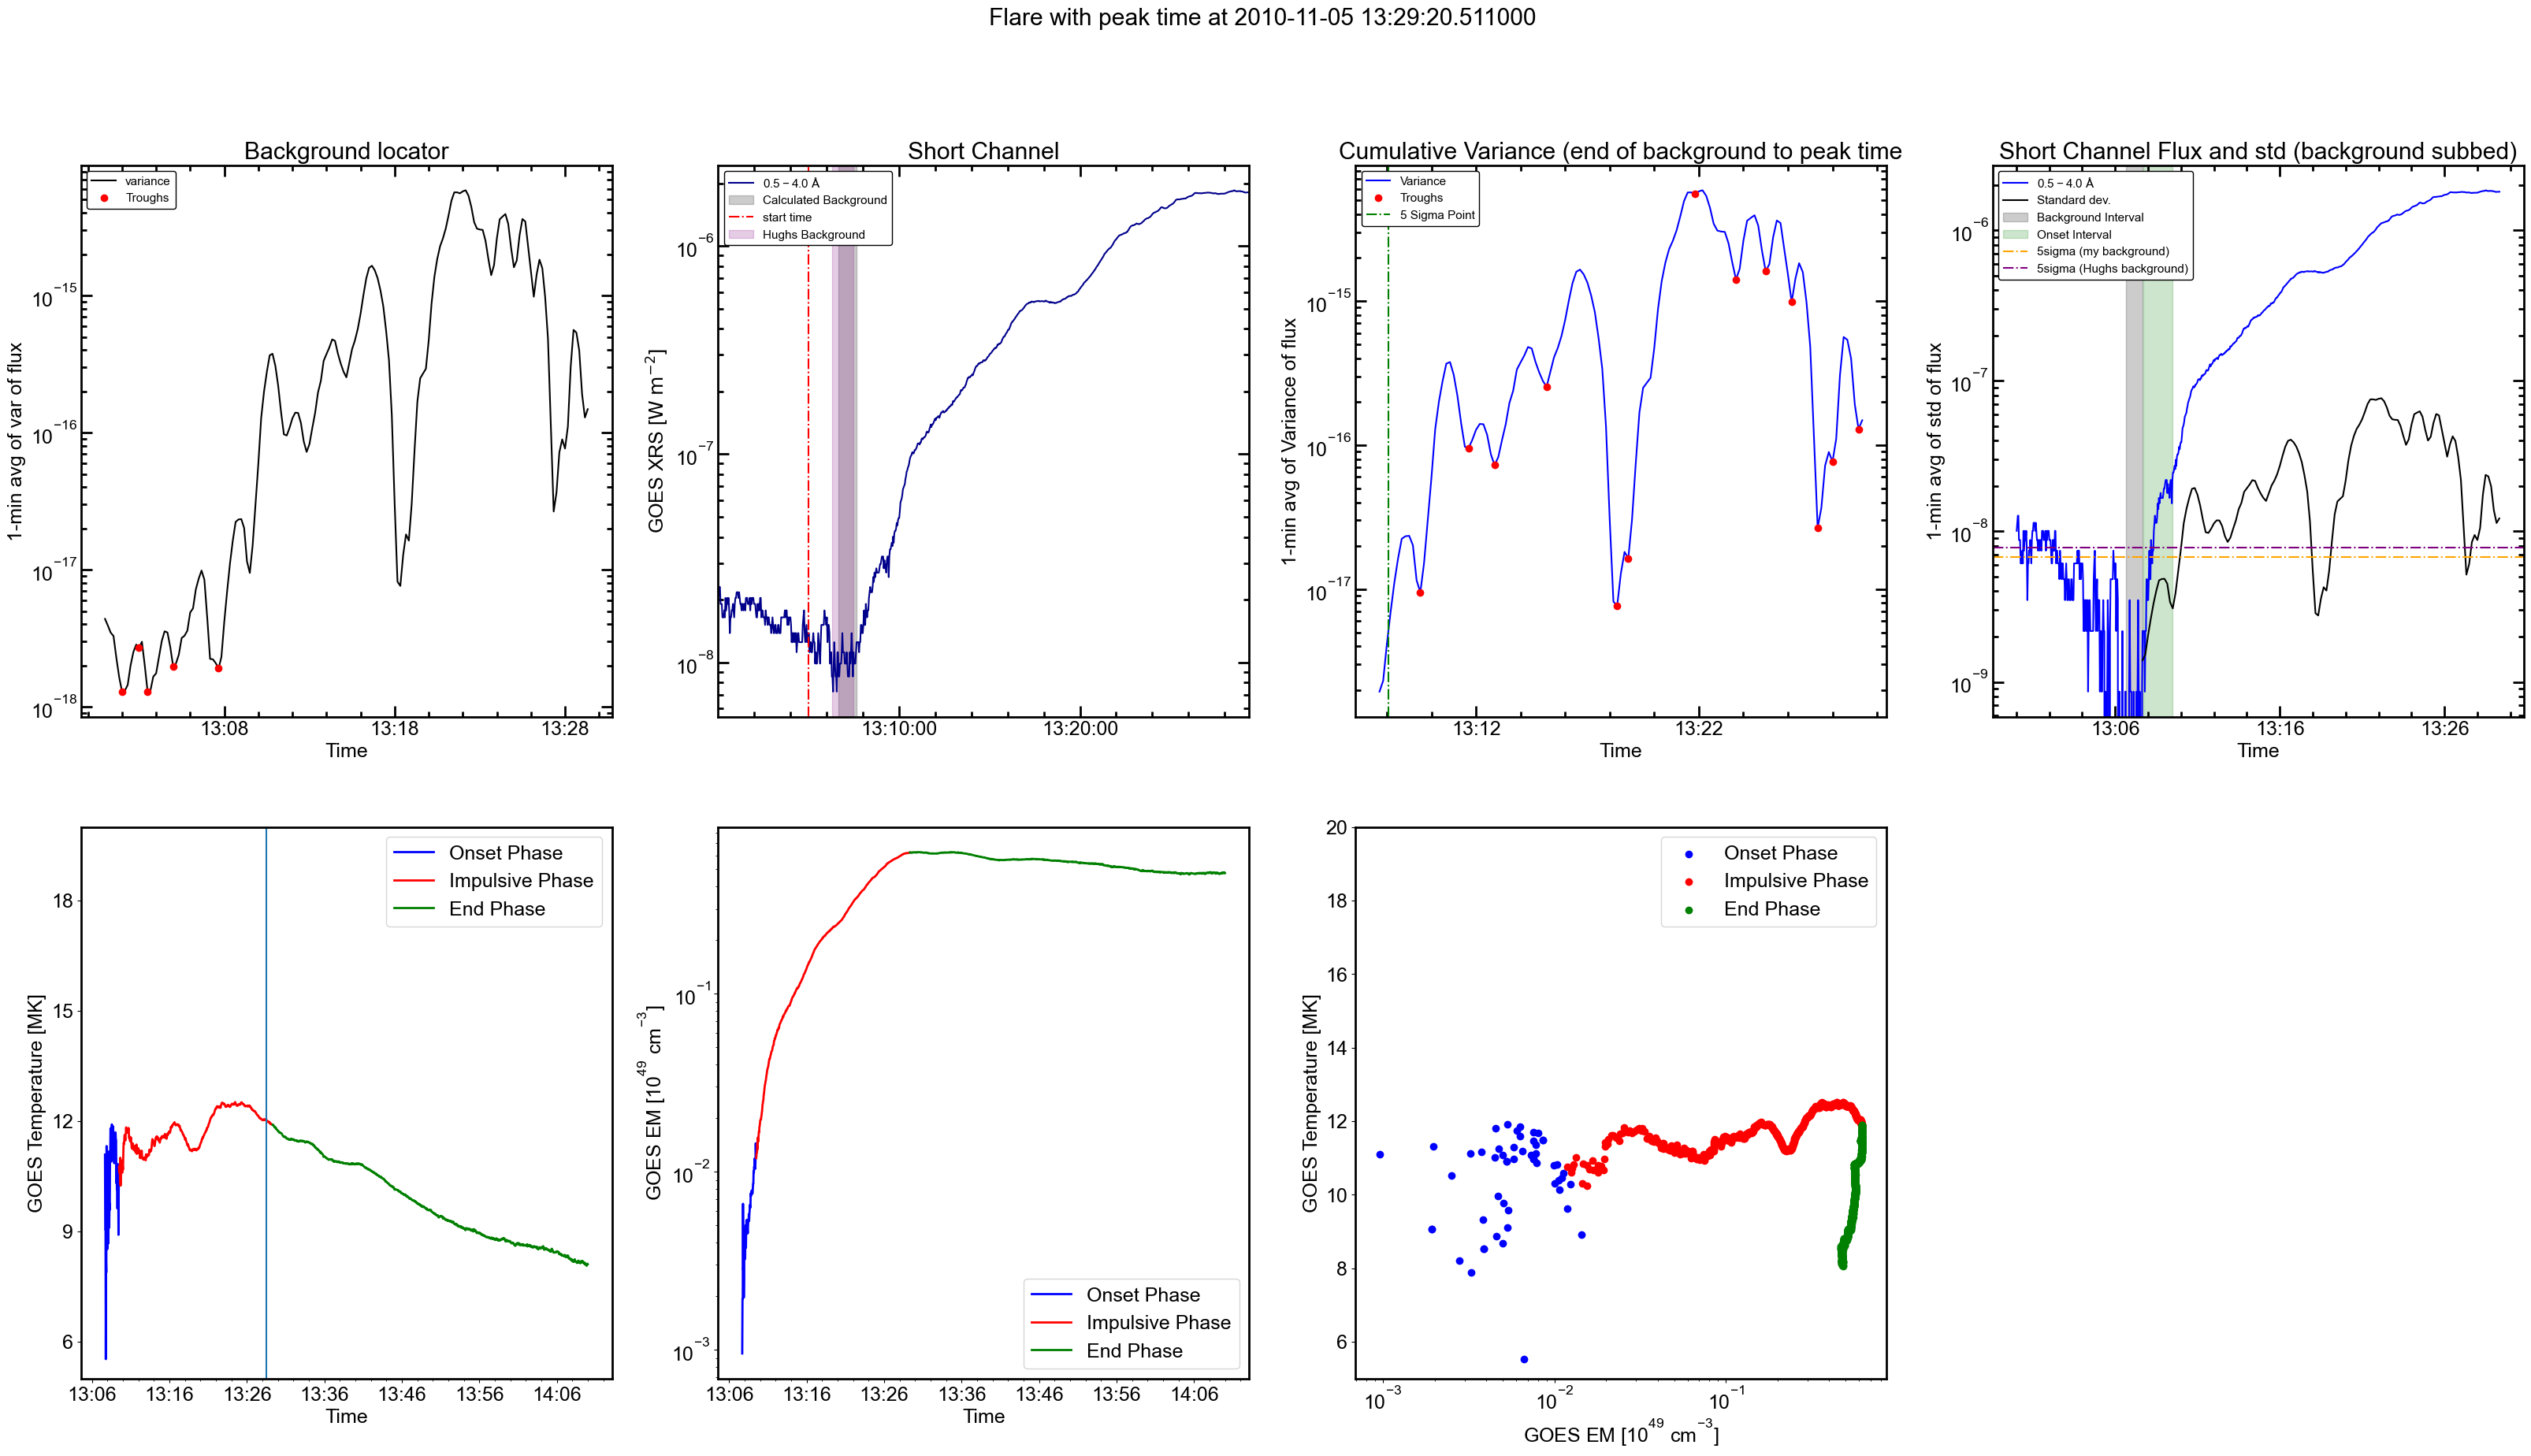


---------Background Time Information---------
Our background timings are between: 2011-02-14 01:31:10 and 2011-02-14 01:32:10
The paper's used backgrounds are 2011-02-14 01:22:09 and 2011-02-14 01:30:47

Our calculated backgrounds are: 6.461e-09 for the short channel and 6.068e-07 for the long channel
The Paper's used backgrounds are: 6.466e-09 for the short channel and 5.896e-07 for the long channel


---------Peak time Information---------
Given peak is: 2011-02-14 01:37:00
Non-backsubbed long channel peak is: 2011-02-14 01:37:09.505000
backsubbed Short channel peak is: 2011-02-14 01:37:09.505000


---------Onset Time Information---------
The start of the onset is calculated to be: 2011-02-14 01:32:12
The end of the onset is calculated to be: 2011-02-14 01:33:20

Mean T during onset: nan MK
Mean EM during onset: nan cm^-3



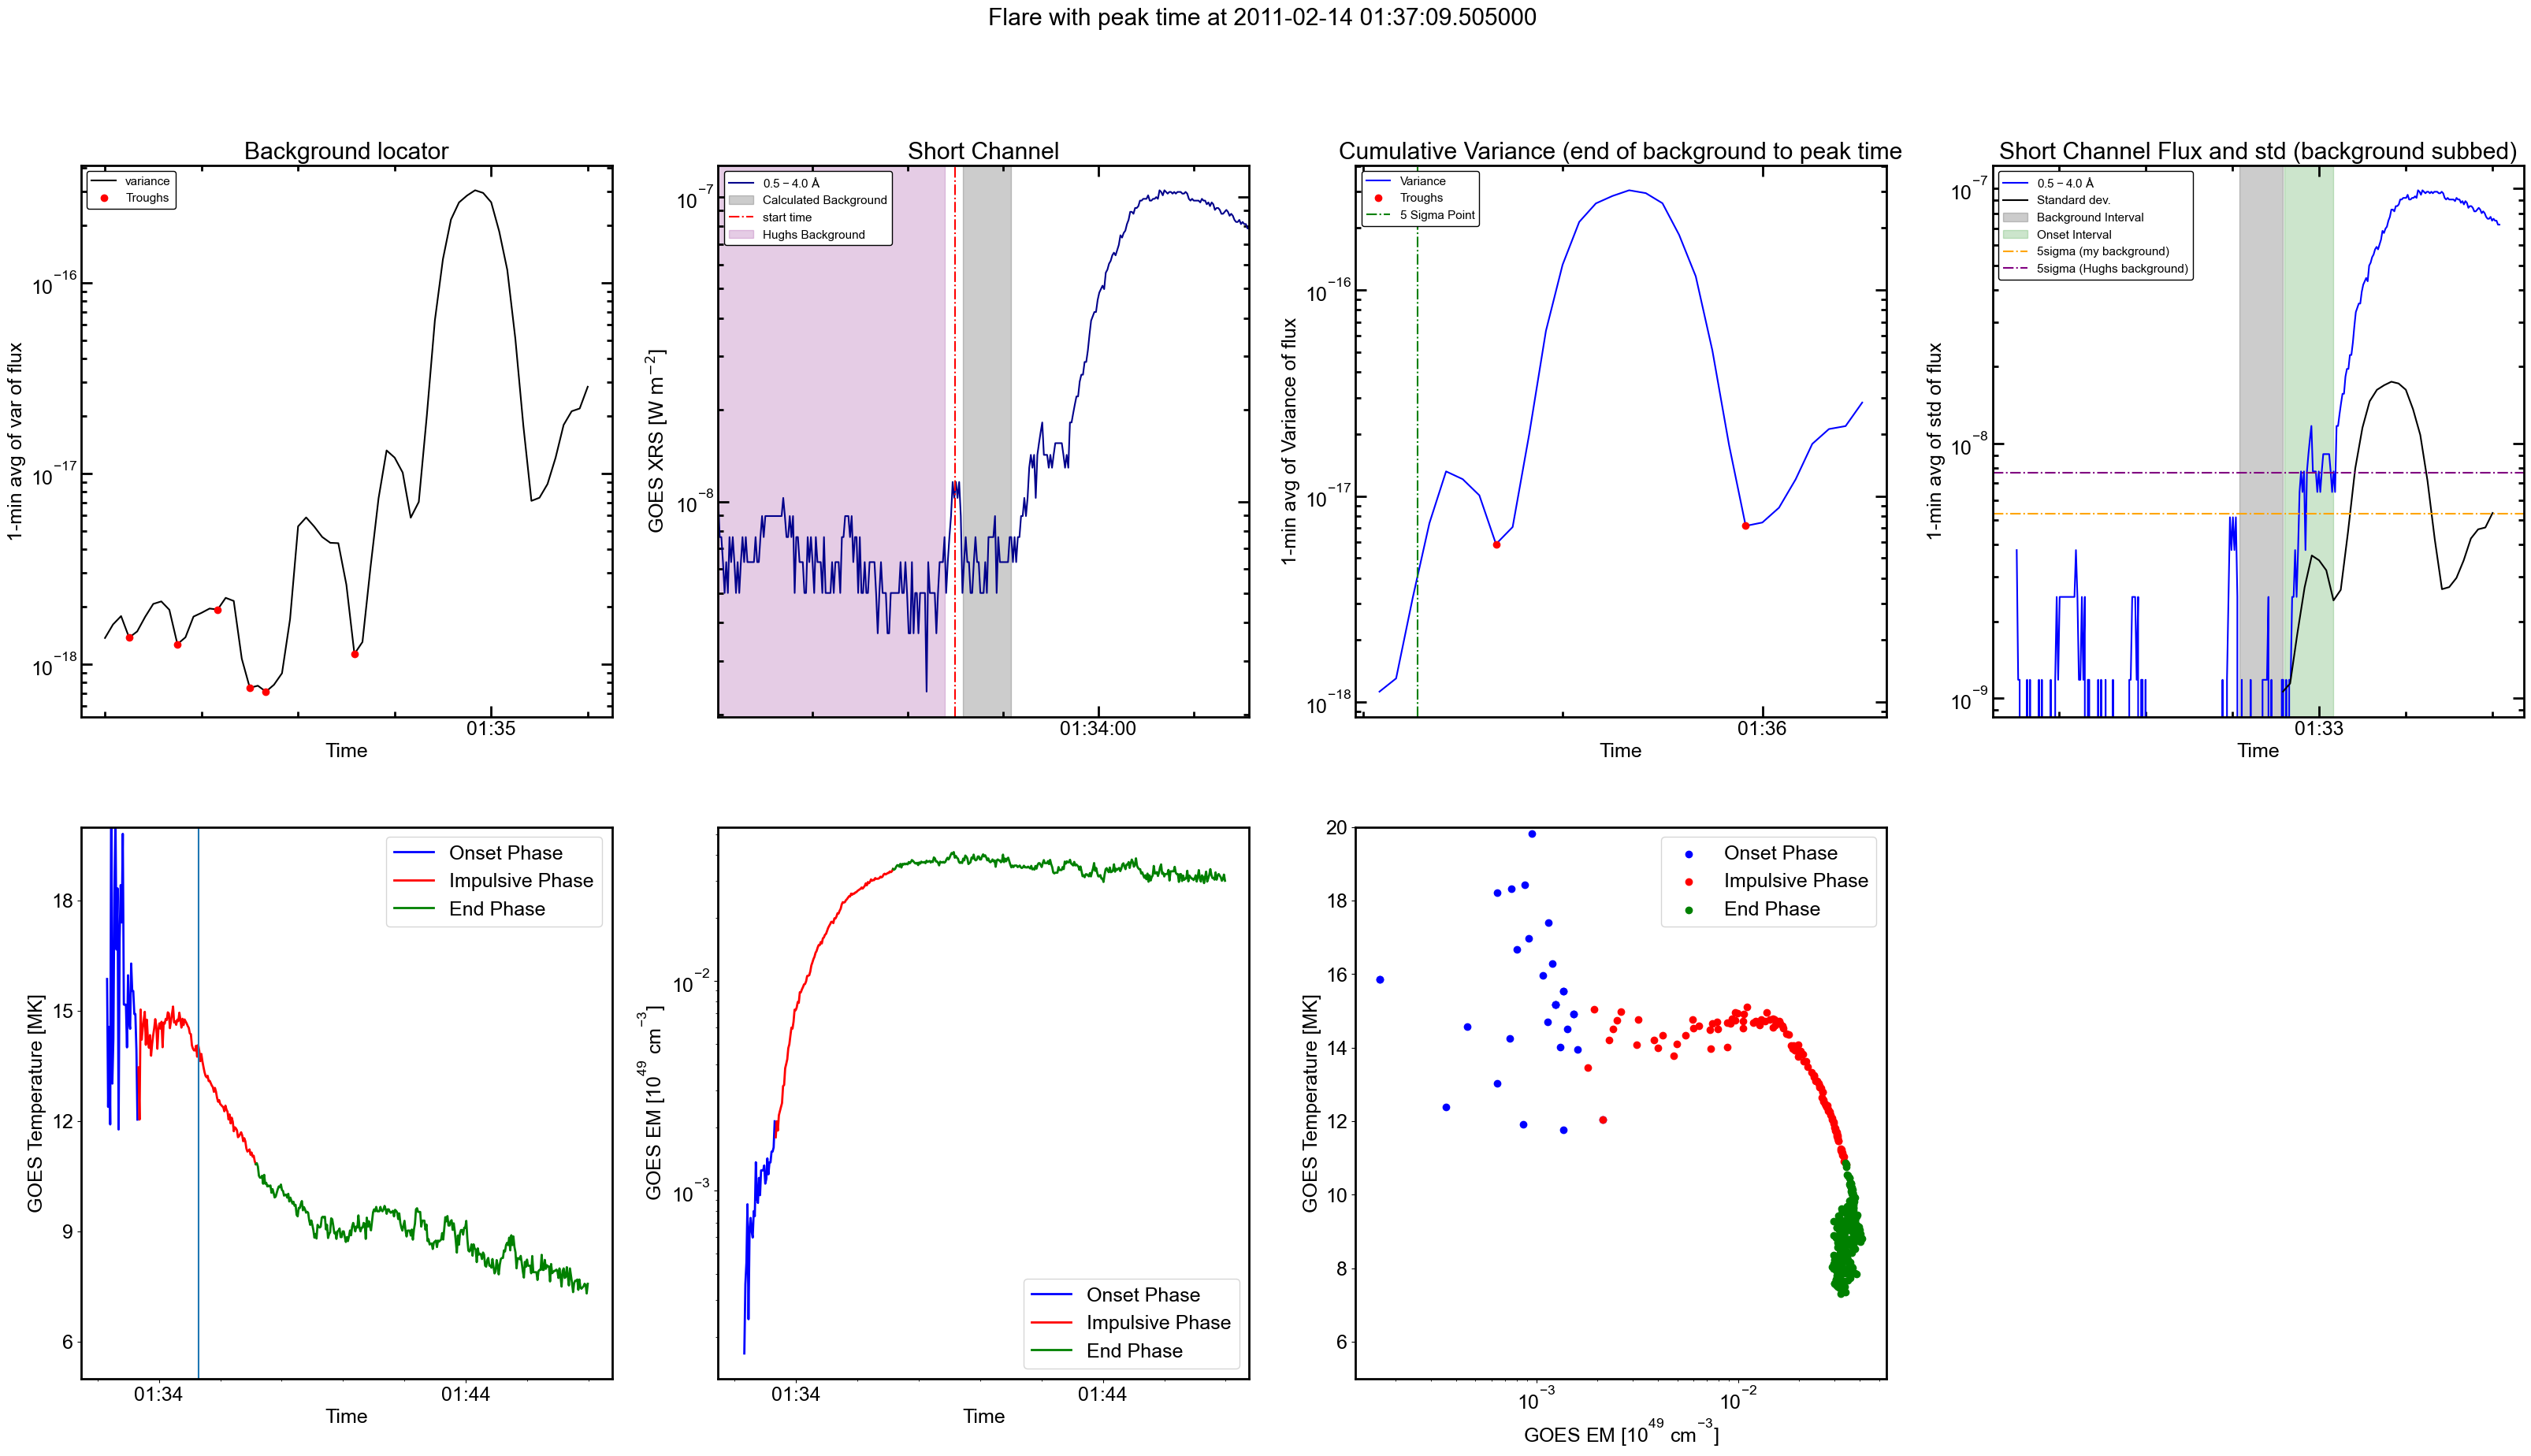


---------Background Time Information---------
Our background timings are between: 2012-05-14 13:34:10 and 2012-05-14 13:35:10
The paper's used backgrounds are 2012-05-14 13:32:16 and 2012-05-14 13:33:38

Our calculated backgrounds are: 5.231e-09 for the short channel and 6.900e-07 for the long channel
The Paper's used backgrounds are: 4.316e-09 for the short channel and 6.863e-07 for the long channel


---------Peak time Information---------
Given peak is: 2012-05-14 13:38:00
Non-backsubbed long channel peak is: 2012-05-14 13:38:25.868000
backsubbed Short channel peak is: 2012-05-14 13:38:25.868000


Not enough troughs located!
Going to caculate the onset time to be 1 minute after the background.

---------Onset Time Information---------
The start of the onset is calculated to be: 2012-05-14 13:35:12
The end of the onset is calculated to be: 2012-05-14 13:36:10

Mean T during onset: 10.05 MK
Mean EM during onset: 5.84e+46 cm^-3



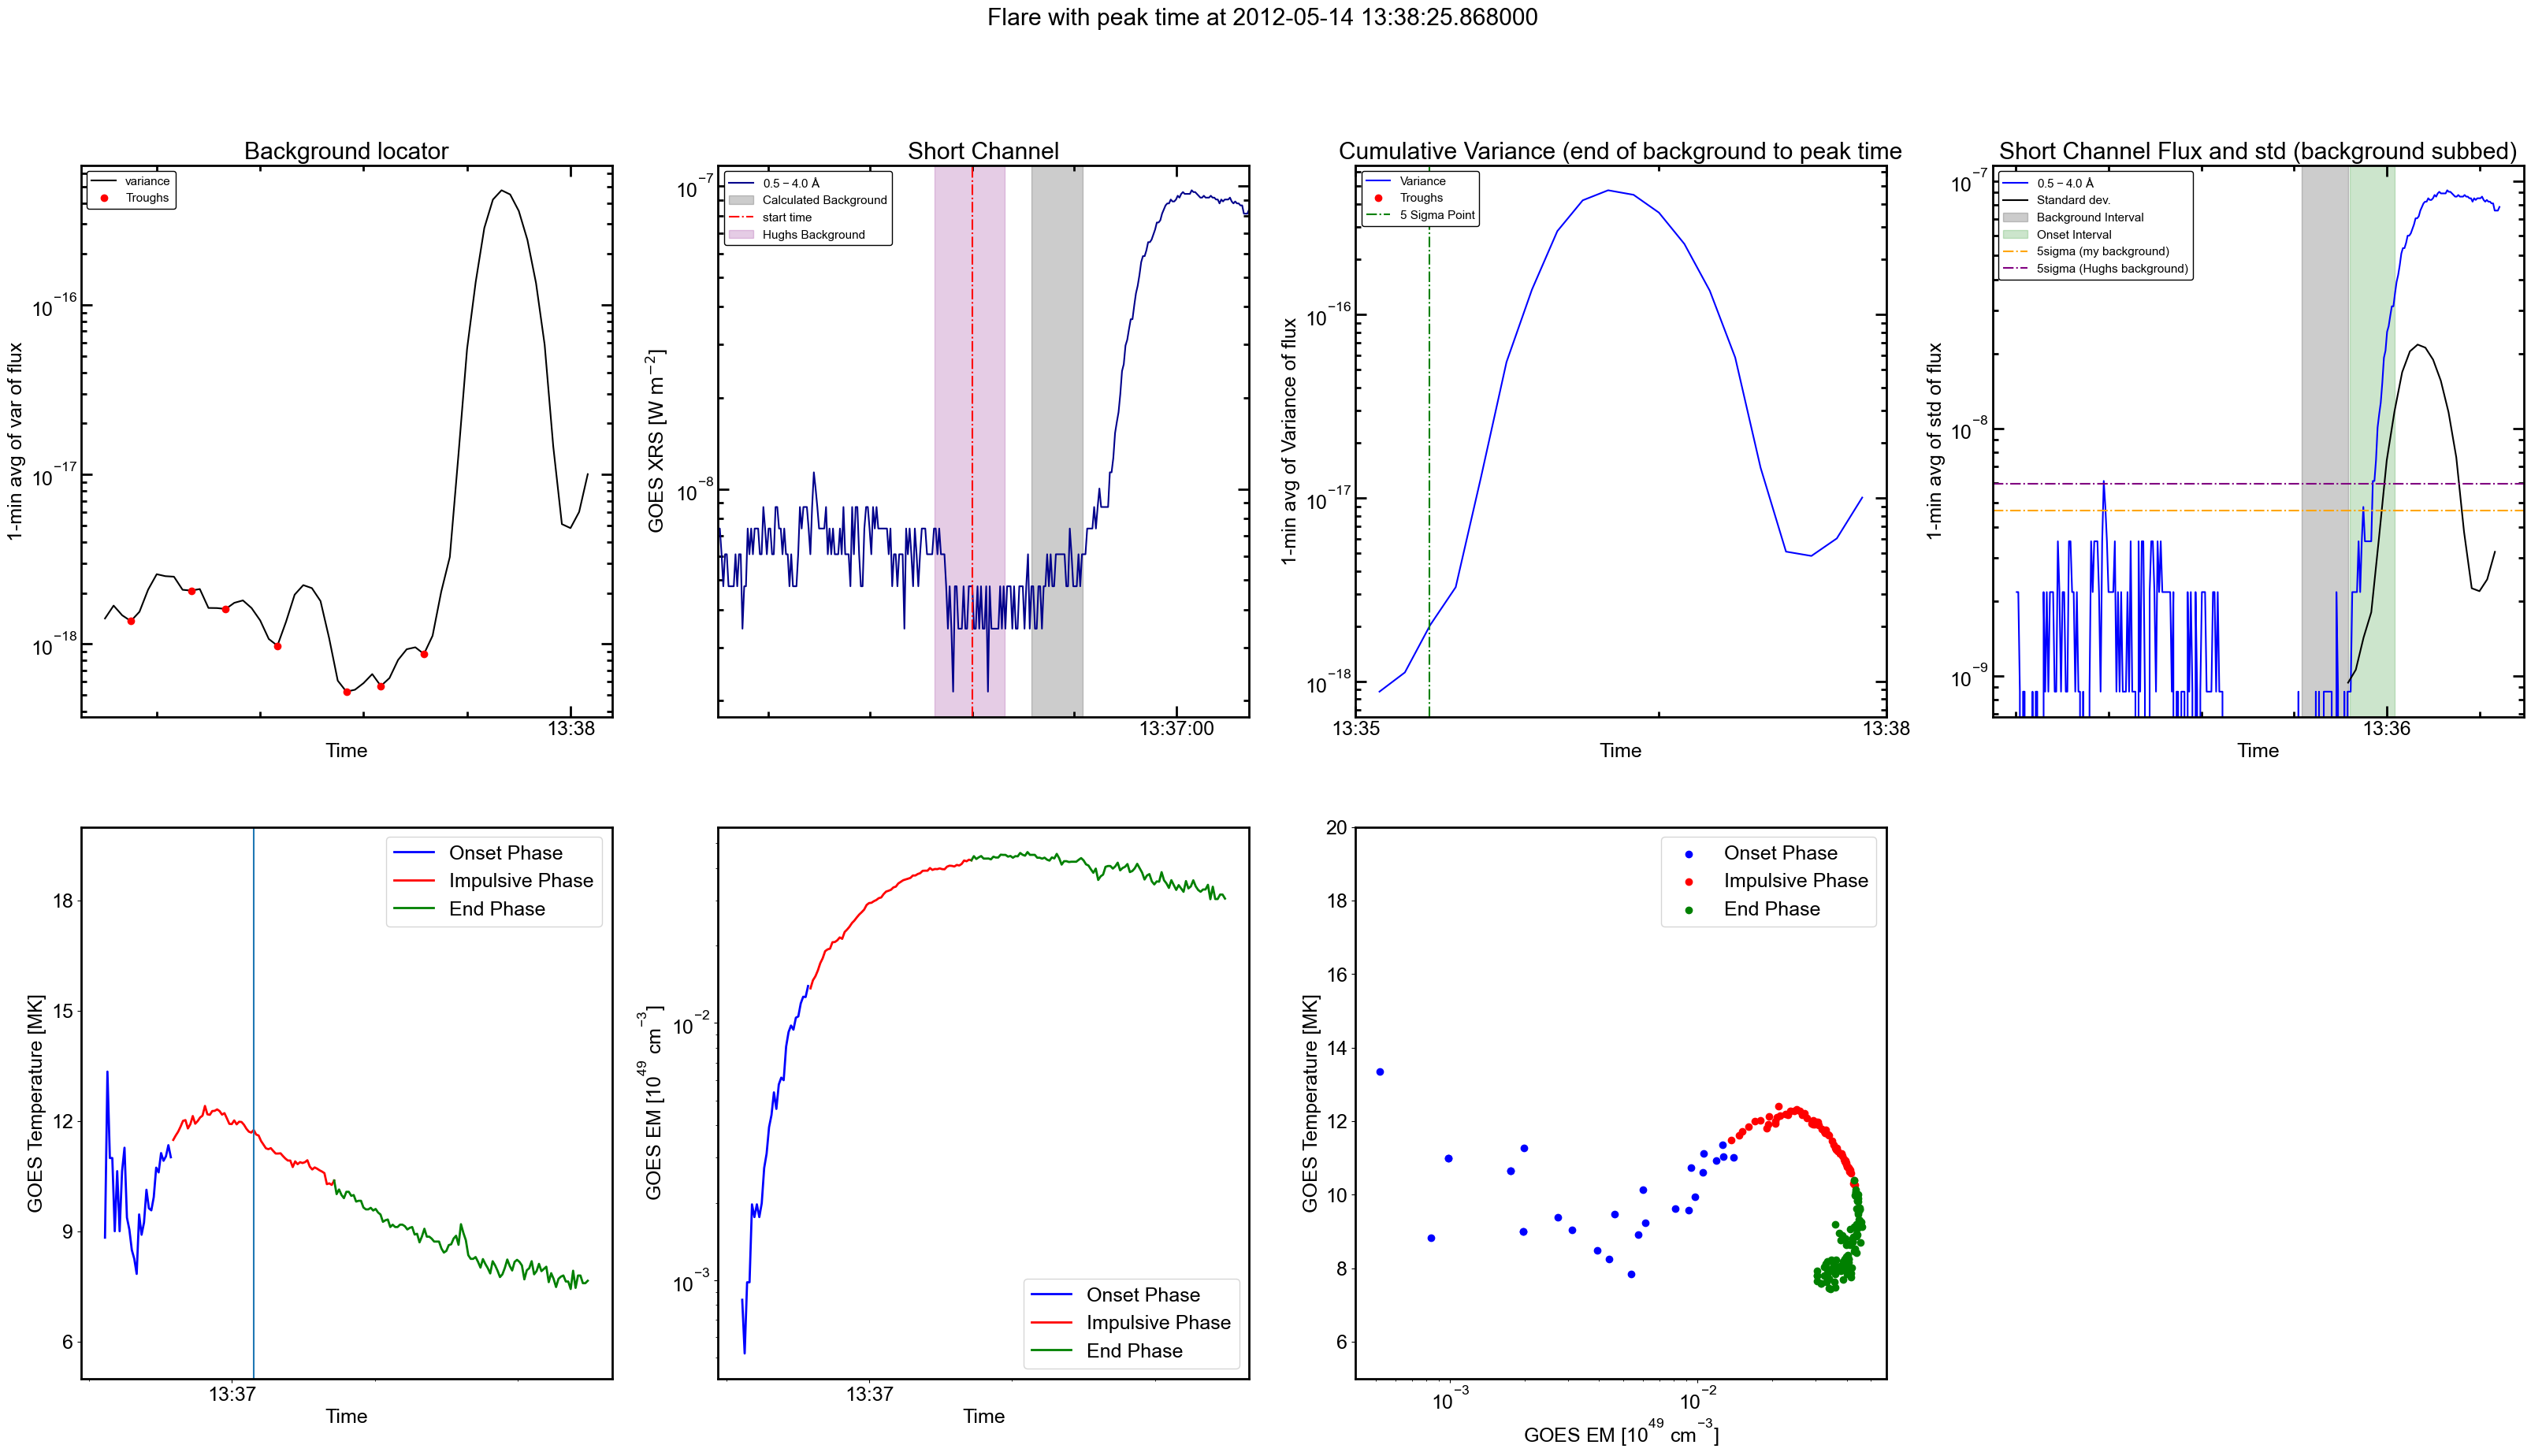


---------Background Time Information---------
Our background timings are between: 2014-01-07 10:07:40 and 2014-01-07 10:08:40
The paper's used backgrounds are 2014-01-07 10:00:57 and 2014-01-07 10:07:36

Our calculated backgrounds are: 7.310e-09 for the short channel and 1.258e-06 for the long channel
The Paper's used backgrounds are: 8.267e-09 for the short channel and 1.259e-06 for the long channel


---------Peak time Information---------
Given peak is: 2014-01-07 10:13:00
Non-backsubbed long channel peak is: 2014-01-07 10:13:09.495000
backsubbed Short channel peak is: 2014-01-07 10:13:09.495000


Not enough troughs located!
Going to caculate the onset time to be 1 minute after the background.

---------Onset Time Information---------
The start of the onset is calculated to be: 2014-01-07 10:08:42
The end of the onset is calculated to be: 2014-01-07 10:09:40

Mean T during onset: nan MK
Mean EM during onset: nan cm^-3



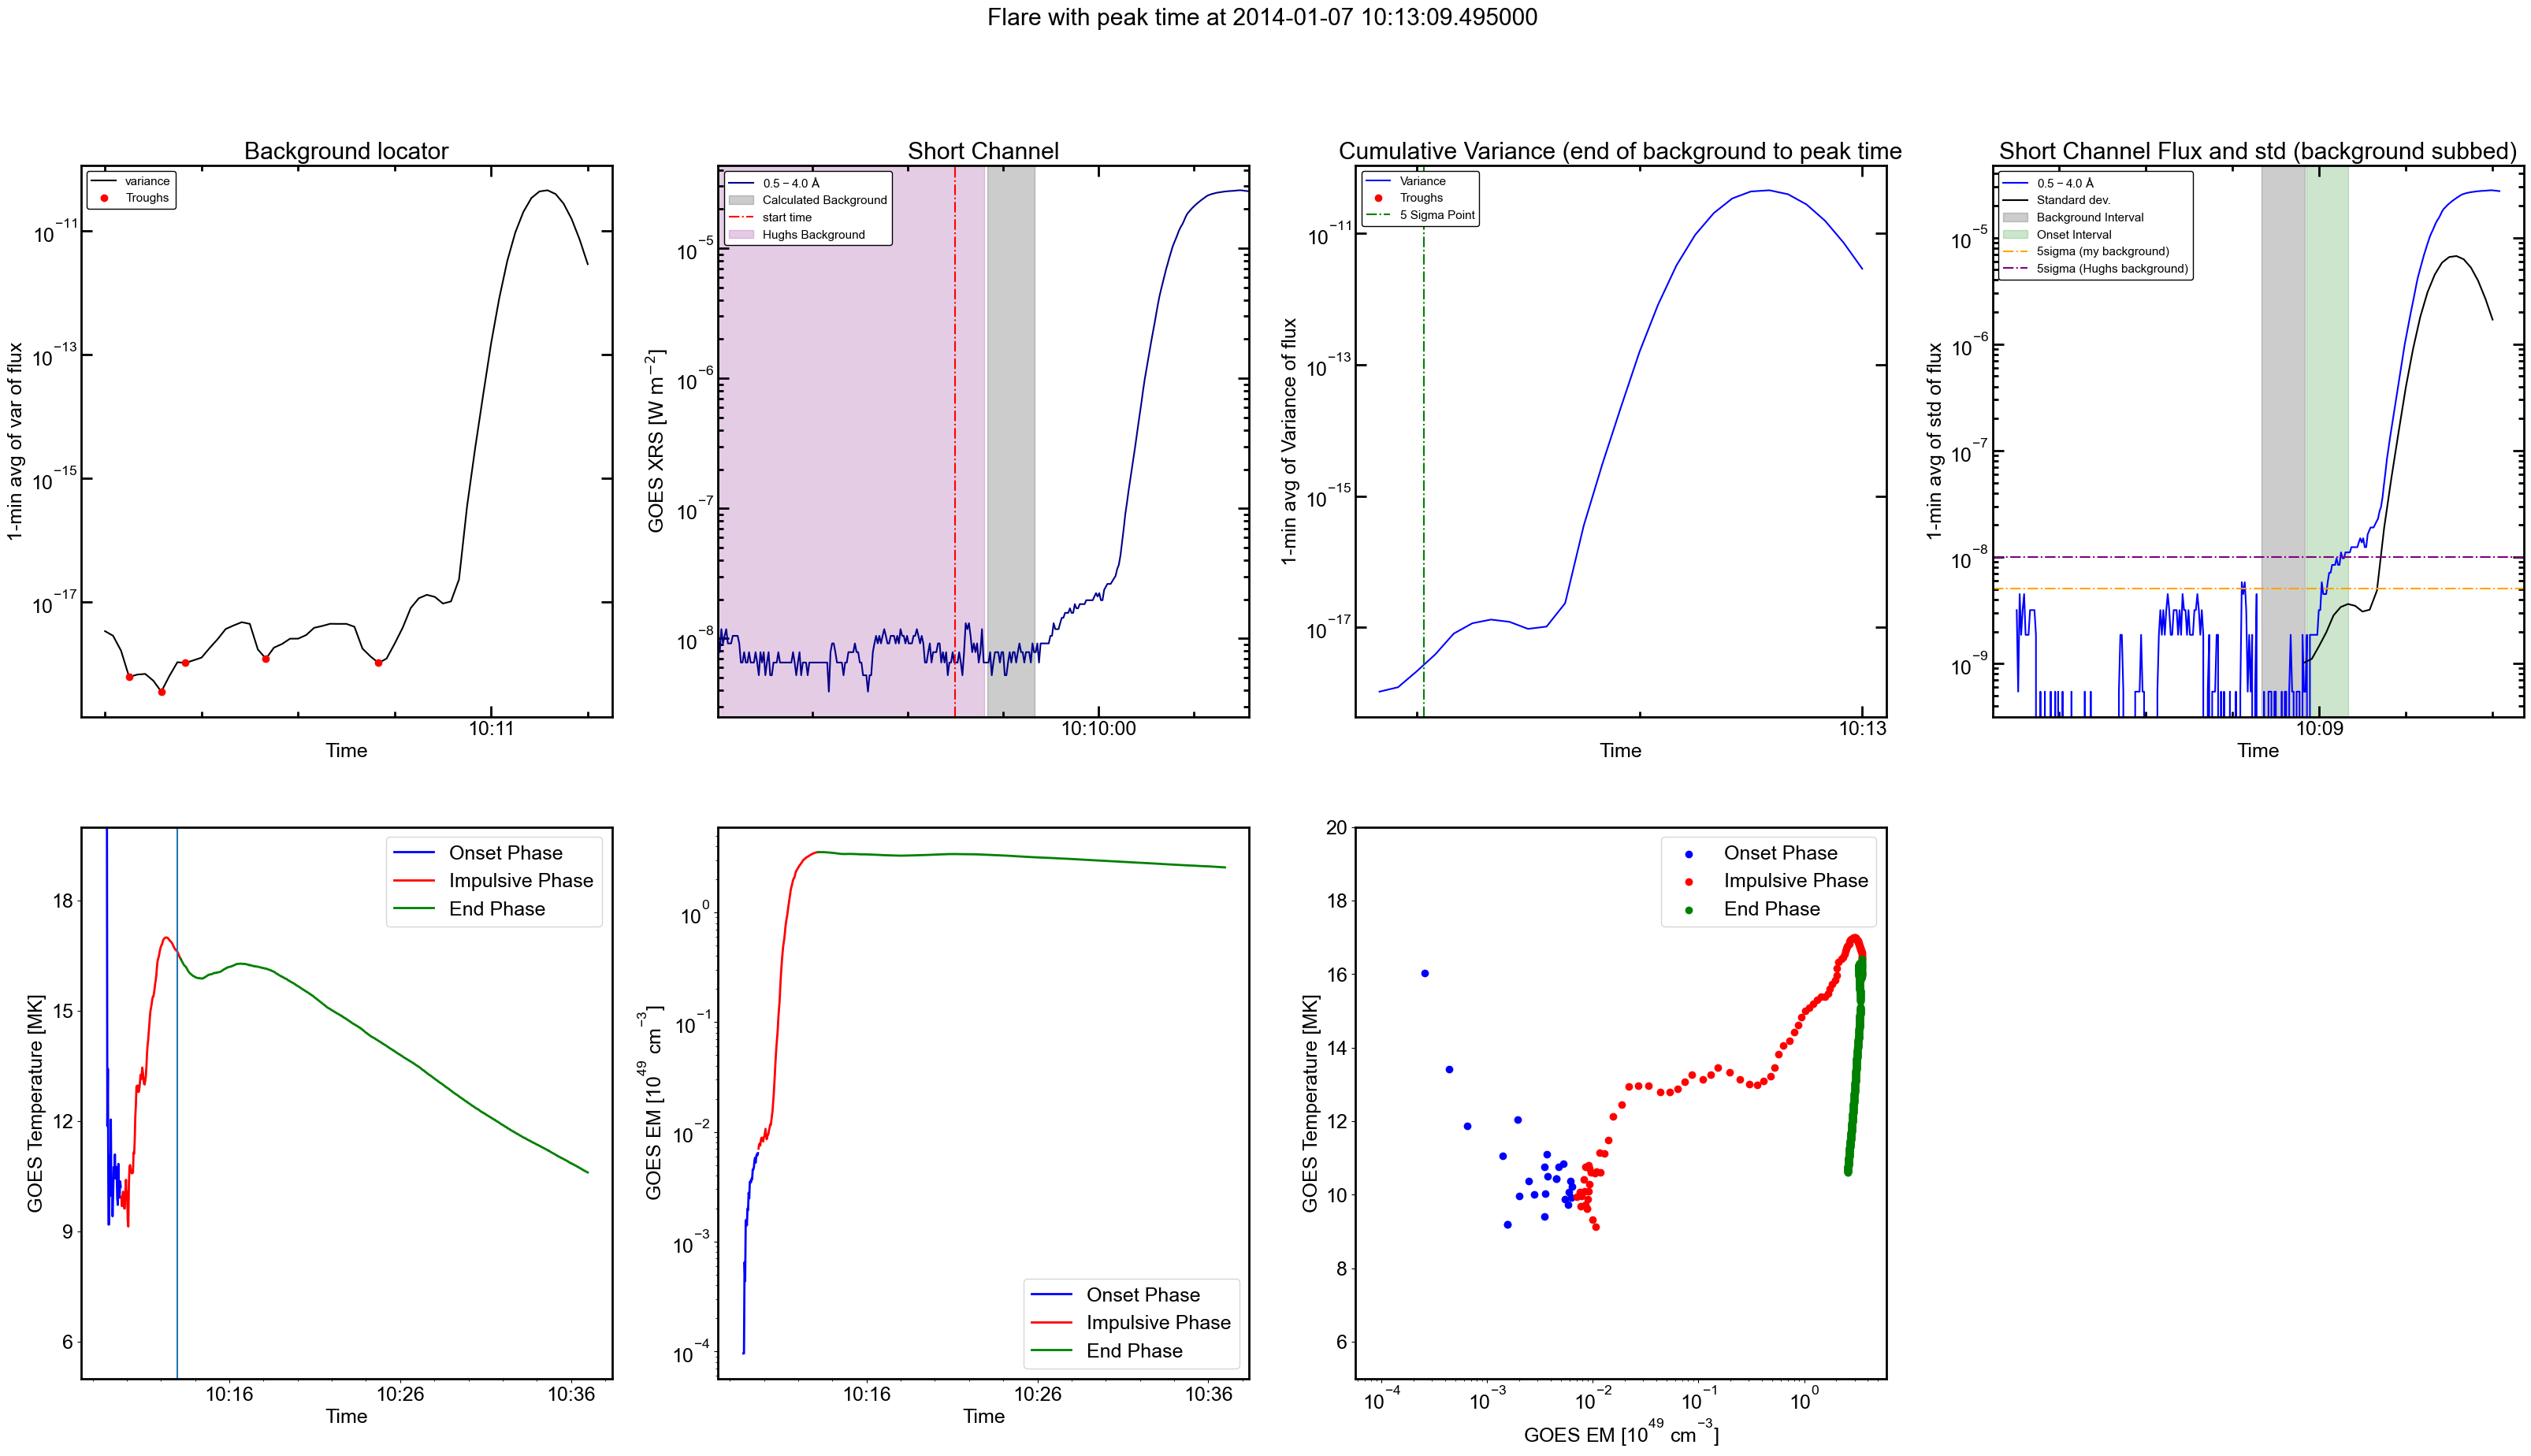


---------Background Time Information---------
Our background timings are between: 2011-08-09 07:45:50 and 2011-08-09 07:46:50
The paper's used backgrounds are 2011-08-09 07:42:49 and 2011-08-09 07:44:32

Our calculated backgrounds are: 4.008e-08 for the short channel and 1.178e-06 for the long channel
The Paper's used backgrounds are: 3.668e-08 for the short channel and 1.134e-06 for the long channel


---------Peak time Information---------
Given peak is: 2011-08-09 08:05:00
Non-backsubbed long channel peak is: 2011-08-09 08:04:54.881000
backsubbed Short channel peak is: 2011-08-09 08:04:54.881000


---------Onset Time Information---------
The start of the onset is calculated to be: 2011-08-09 07:46:52
The end of the onset is calculated to be: 2011-08-09 07:49:00

Mean T during onset: nan MK
Mean EM during onset: nan cm^-3



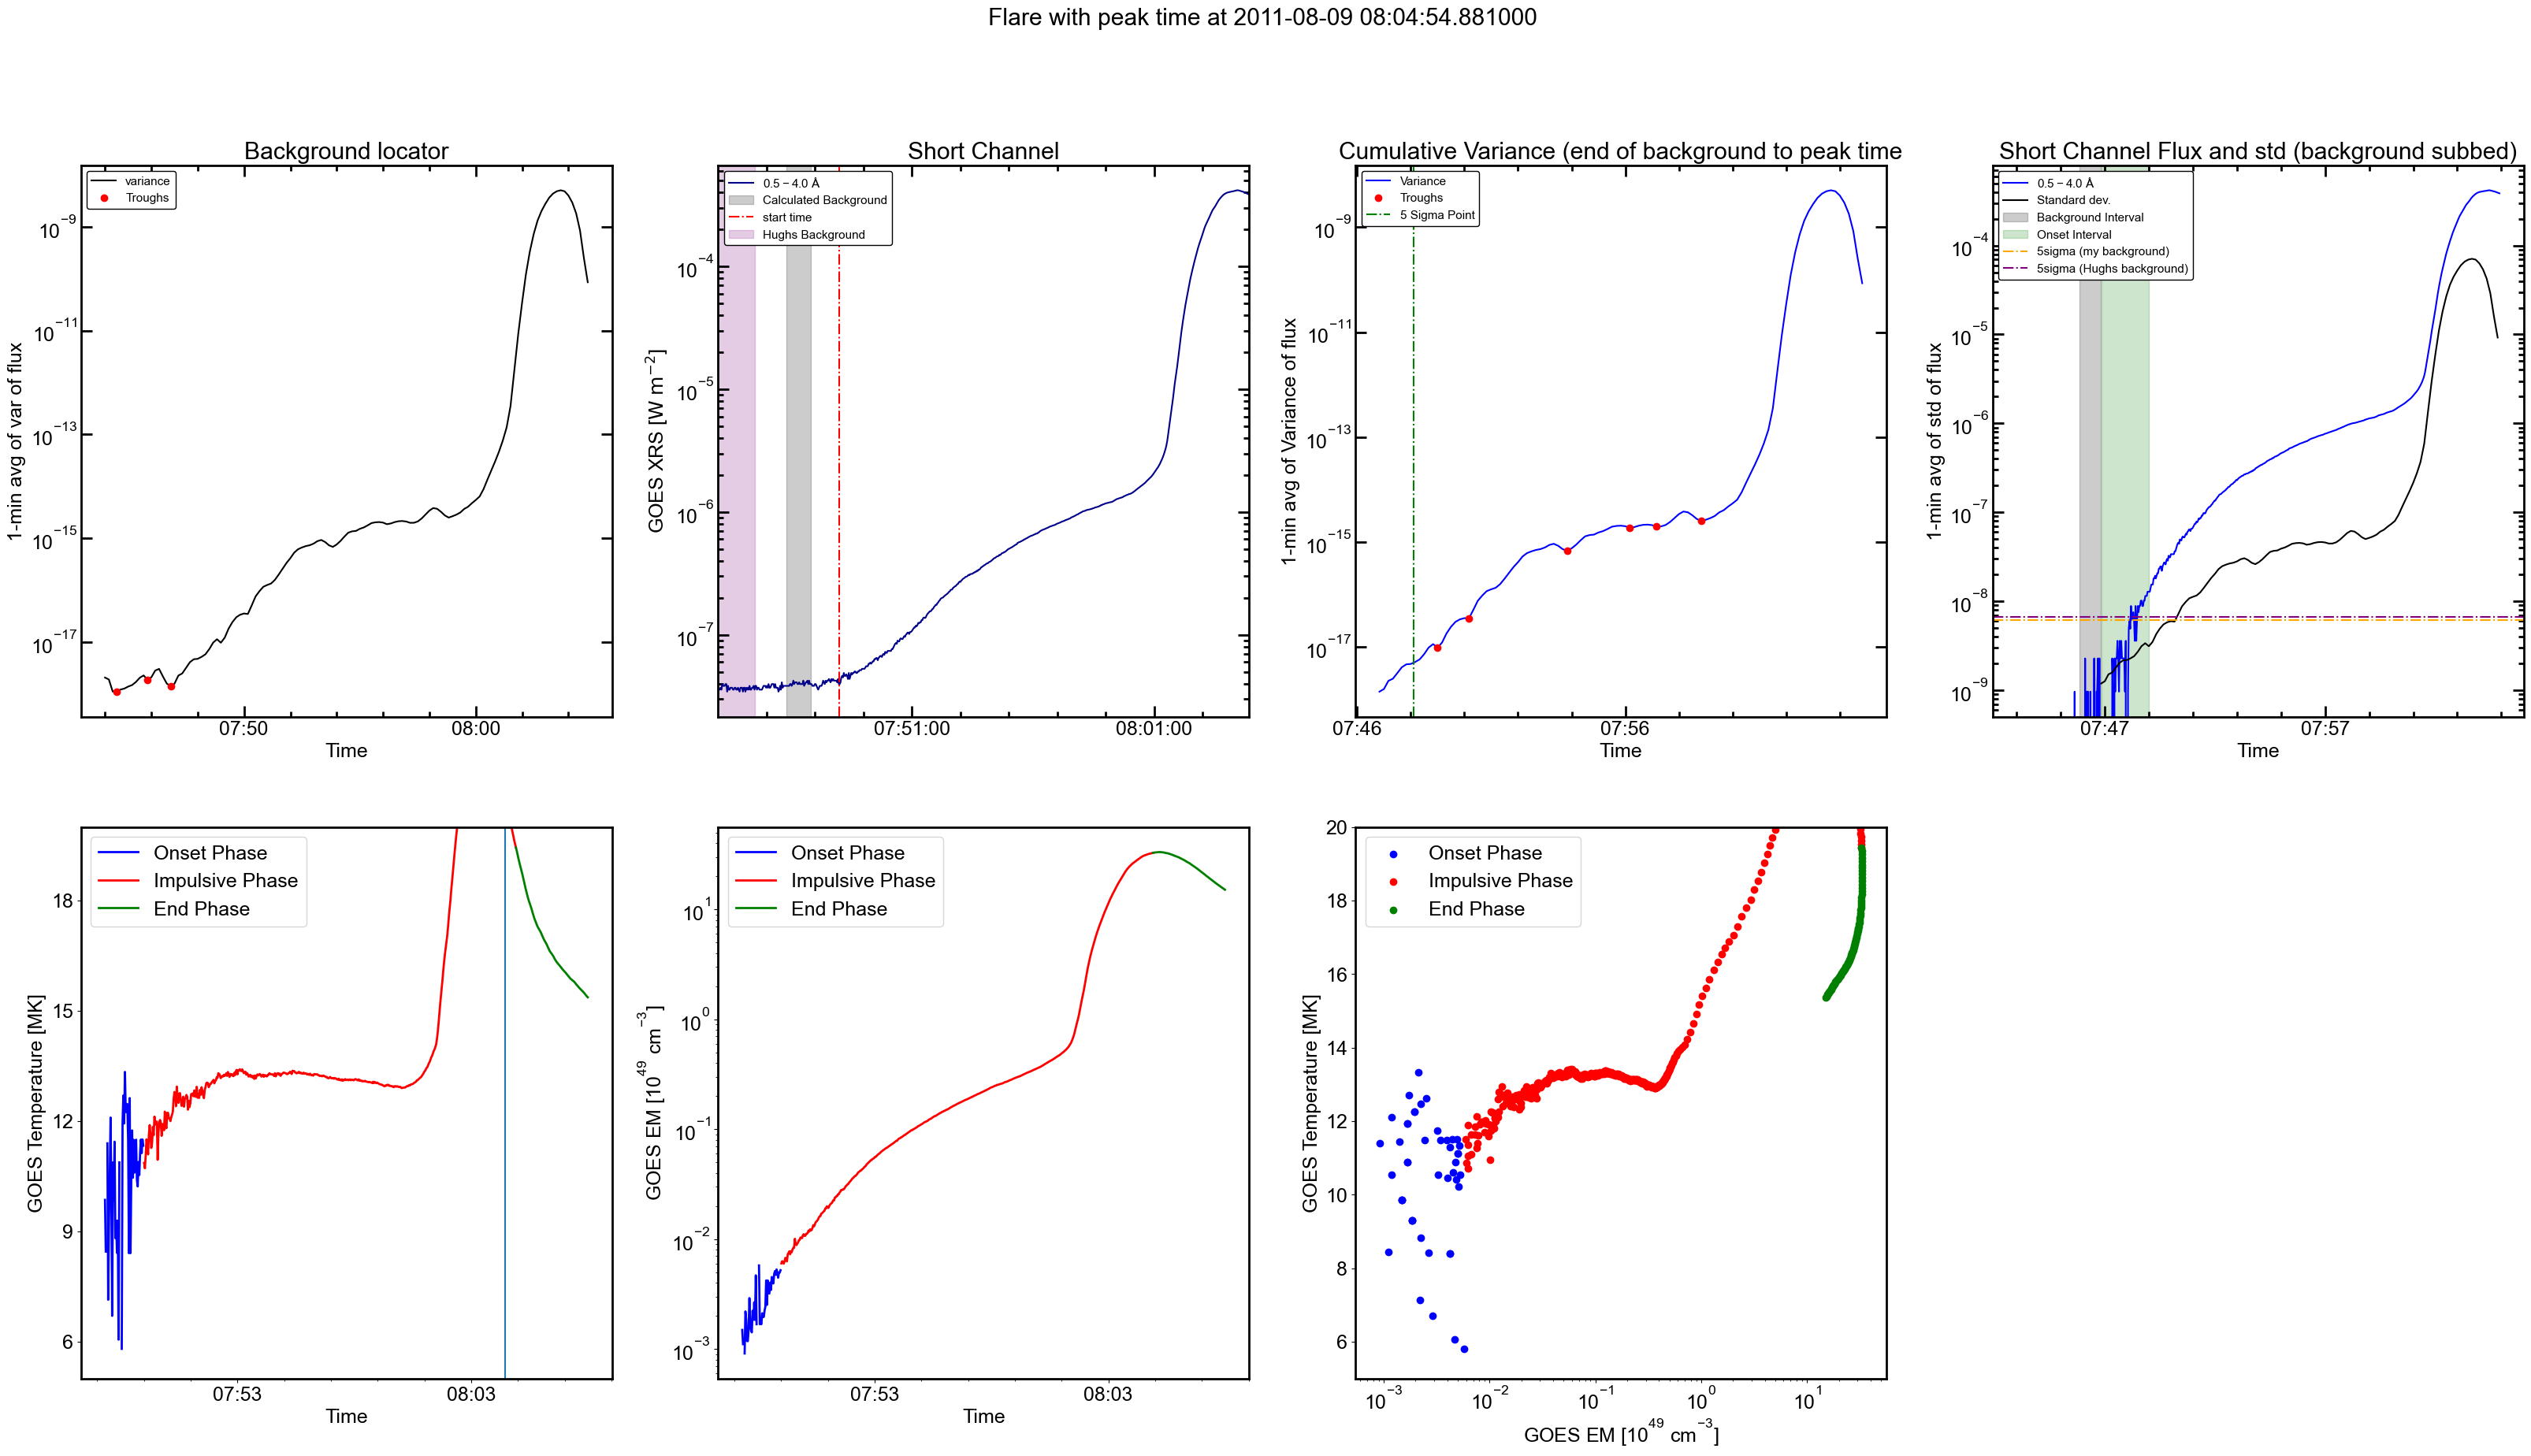


---------Background Time Information---------
Our background timings are between: 2013-03-15 05:51:40 and 2013-03-15 05:52:40
The paper's used backgrounds are 2013-03-15 05:45:00 and 2013-03-15 05:46:43

Our calculated backgrounds are: 2.989e-09 for the short channel and 6.316e-07 for the long channel
The Paper's used backgrounds are: -1.698e-10 for the short channel and 6.135e-07 for the long channel


---------Peak time Information---------
Given peak is: 2013-03-15 06:58:00
Non-backsubbed long channel peak is: 2013-03-15 07:01:26.301000
backsubbed Short channel peak is: 2013-03-15 07:01:26.301000


---------Onset Time Information---------
The start of the onset is calculated to be: 2013-03-15 05:54:00
The end of the onset is calculated to be: 2013-03-15 05:54:30

Mean T during onset: 8.57 MK
Mean EM during onset: 4.66e+46 cm^-3



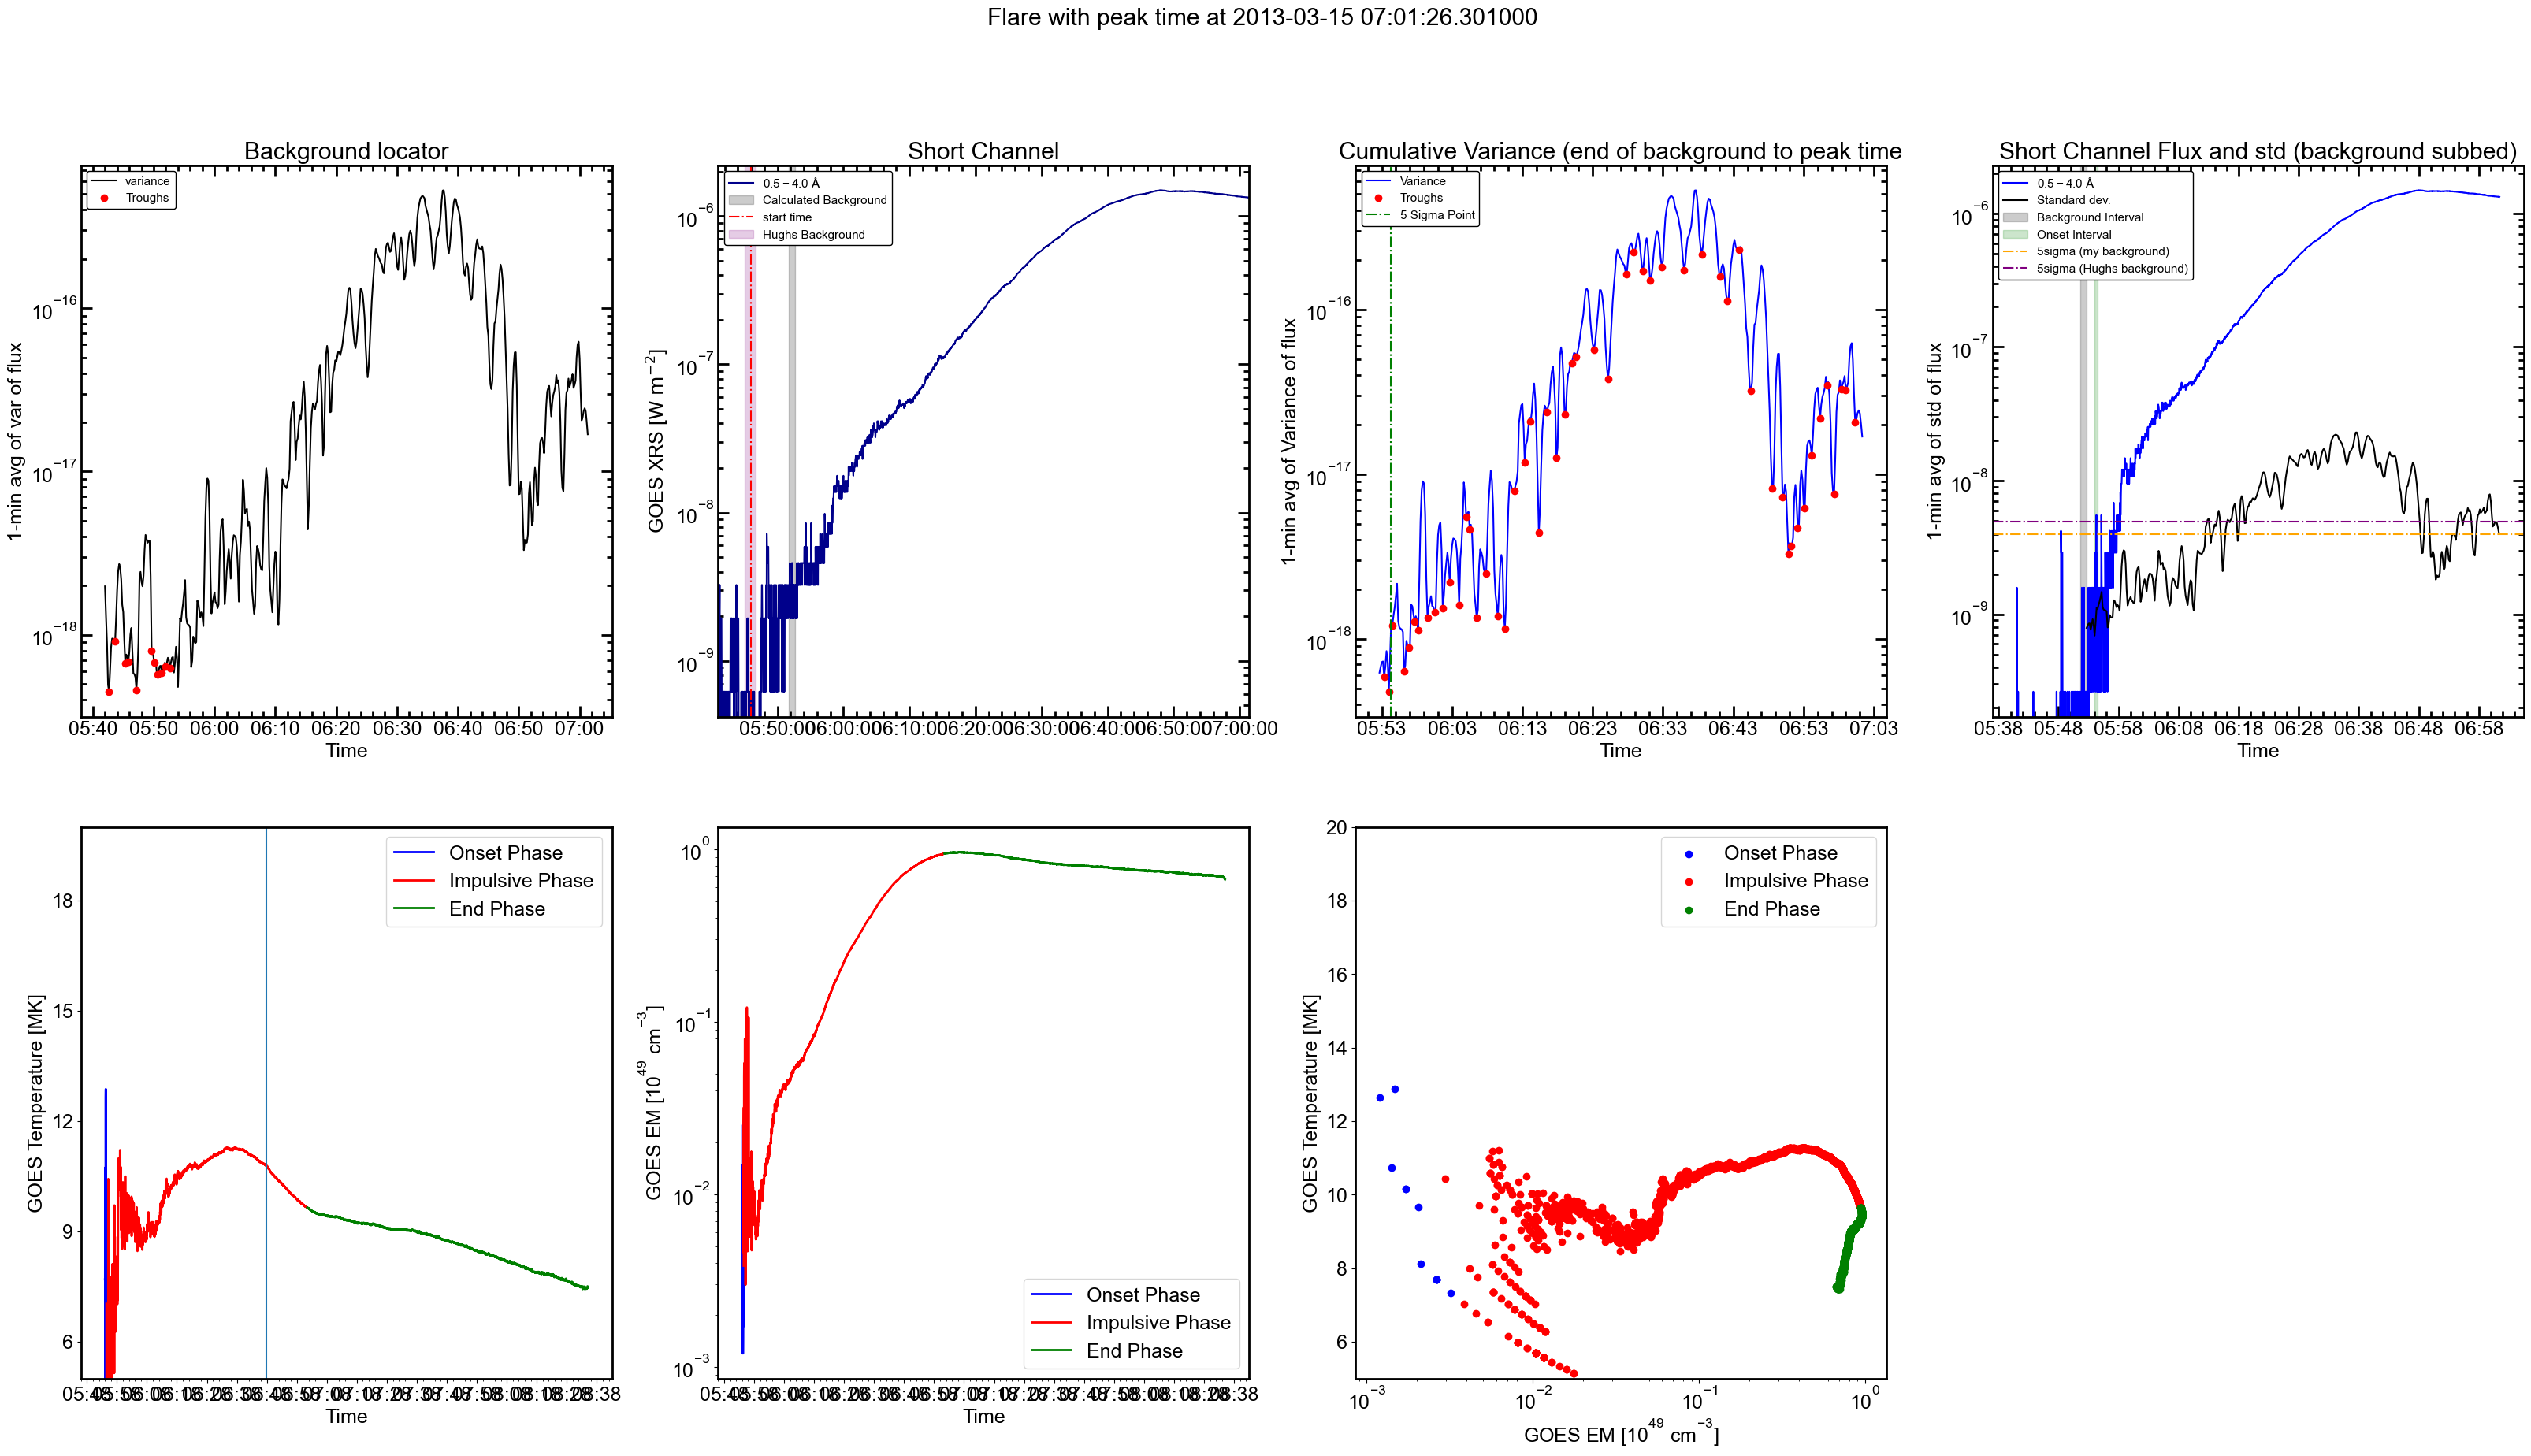


---------Background Time Information---------
Our background timings are between: 2013-05-15 01:24:20 and 2013-05-15 01:25:20
The paper's used backgrounds are 2013-05-15 01:08:00 and 2013-05-15 01:08:40

Our calculated backgrounds are: 3.455e-07 for the short channel and 4.522e-06 for the long channel
The Paper's used backgrounds are: 4.648e-08 for the short channel and 1.926e-06 for the long channel


---------Peak time Information---------
Given peak is: 2013-05-15 01:48:00
Non-backsubbed long channel peak is: 2013-05-15 01:48:02.315000
backsubbed Short channel peak is: 2013-05-15 01:48:02.315000


---------Onset Time Information---------
The start of the onset is calculated to be: 2013-05-15 01:25:22
The end of the onset is calculated to be: 2013-05-15 01:27:50

Mean T during onset: 12.42 MK
Mean EM during onset: 3.79e+47 cm^-3



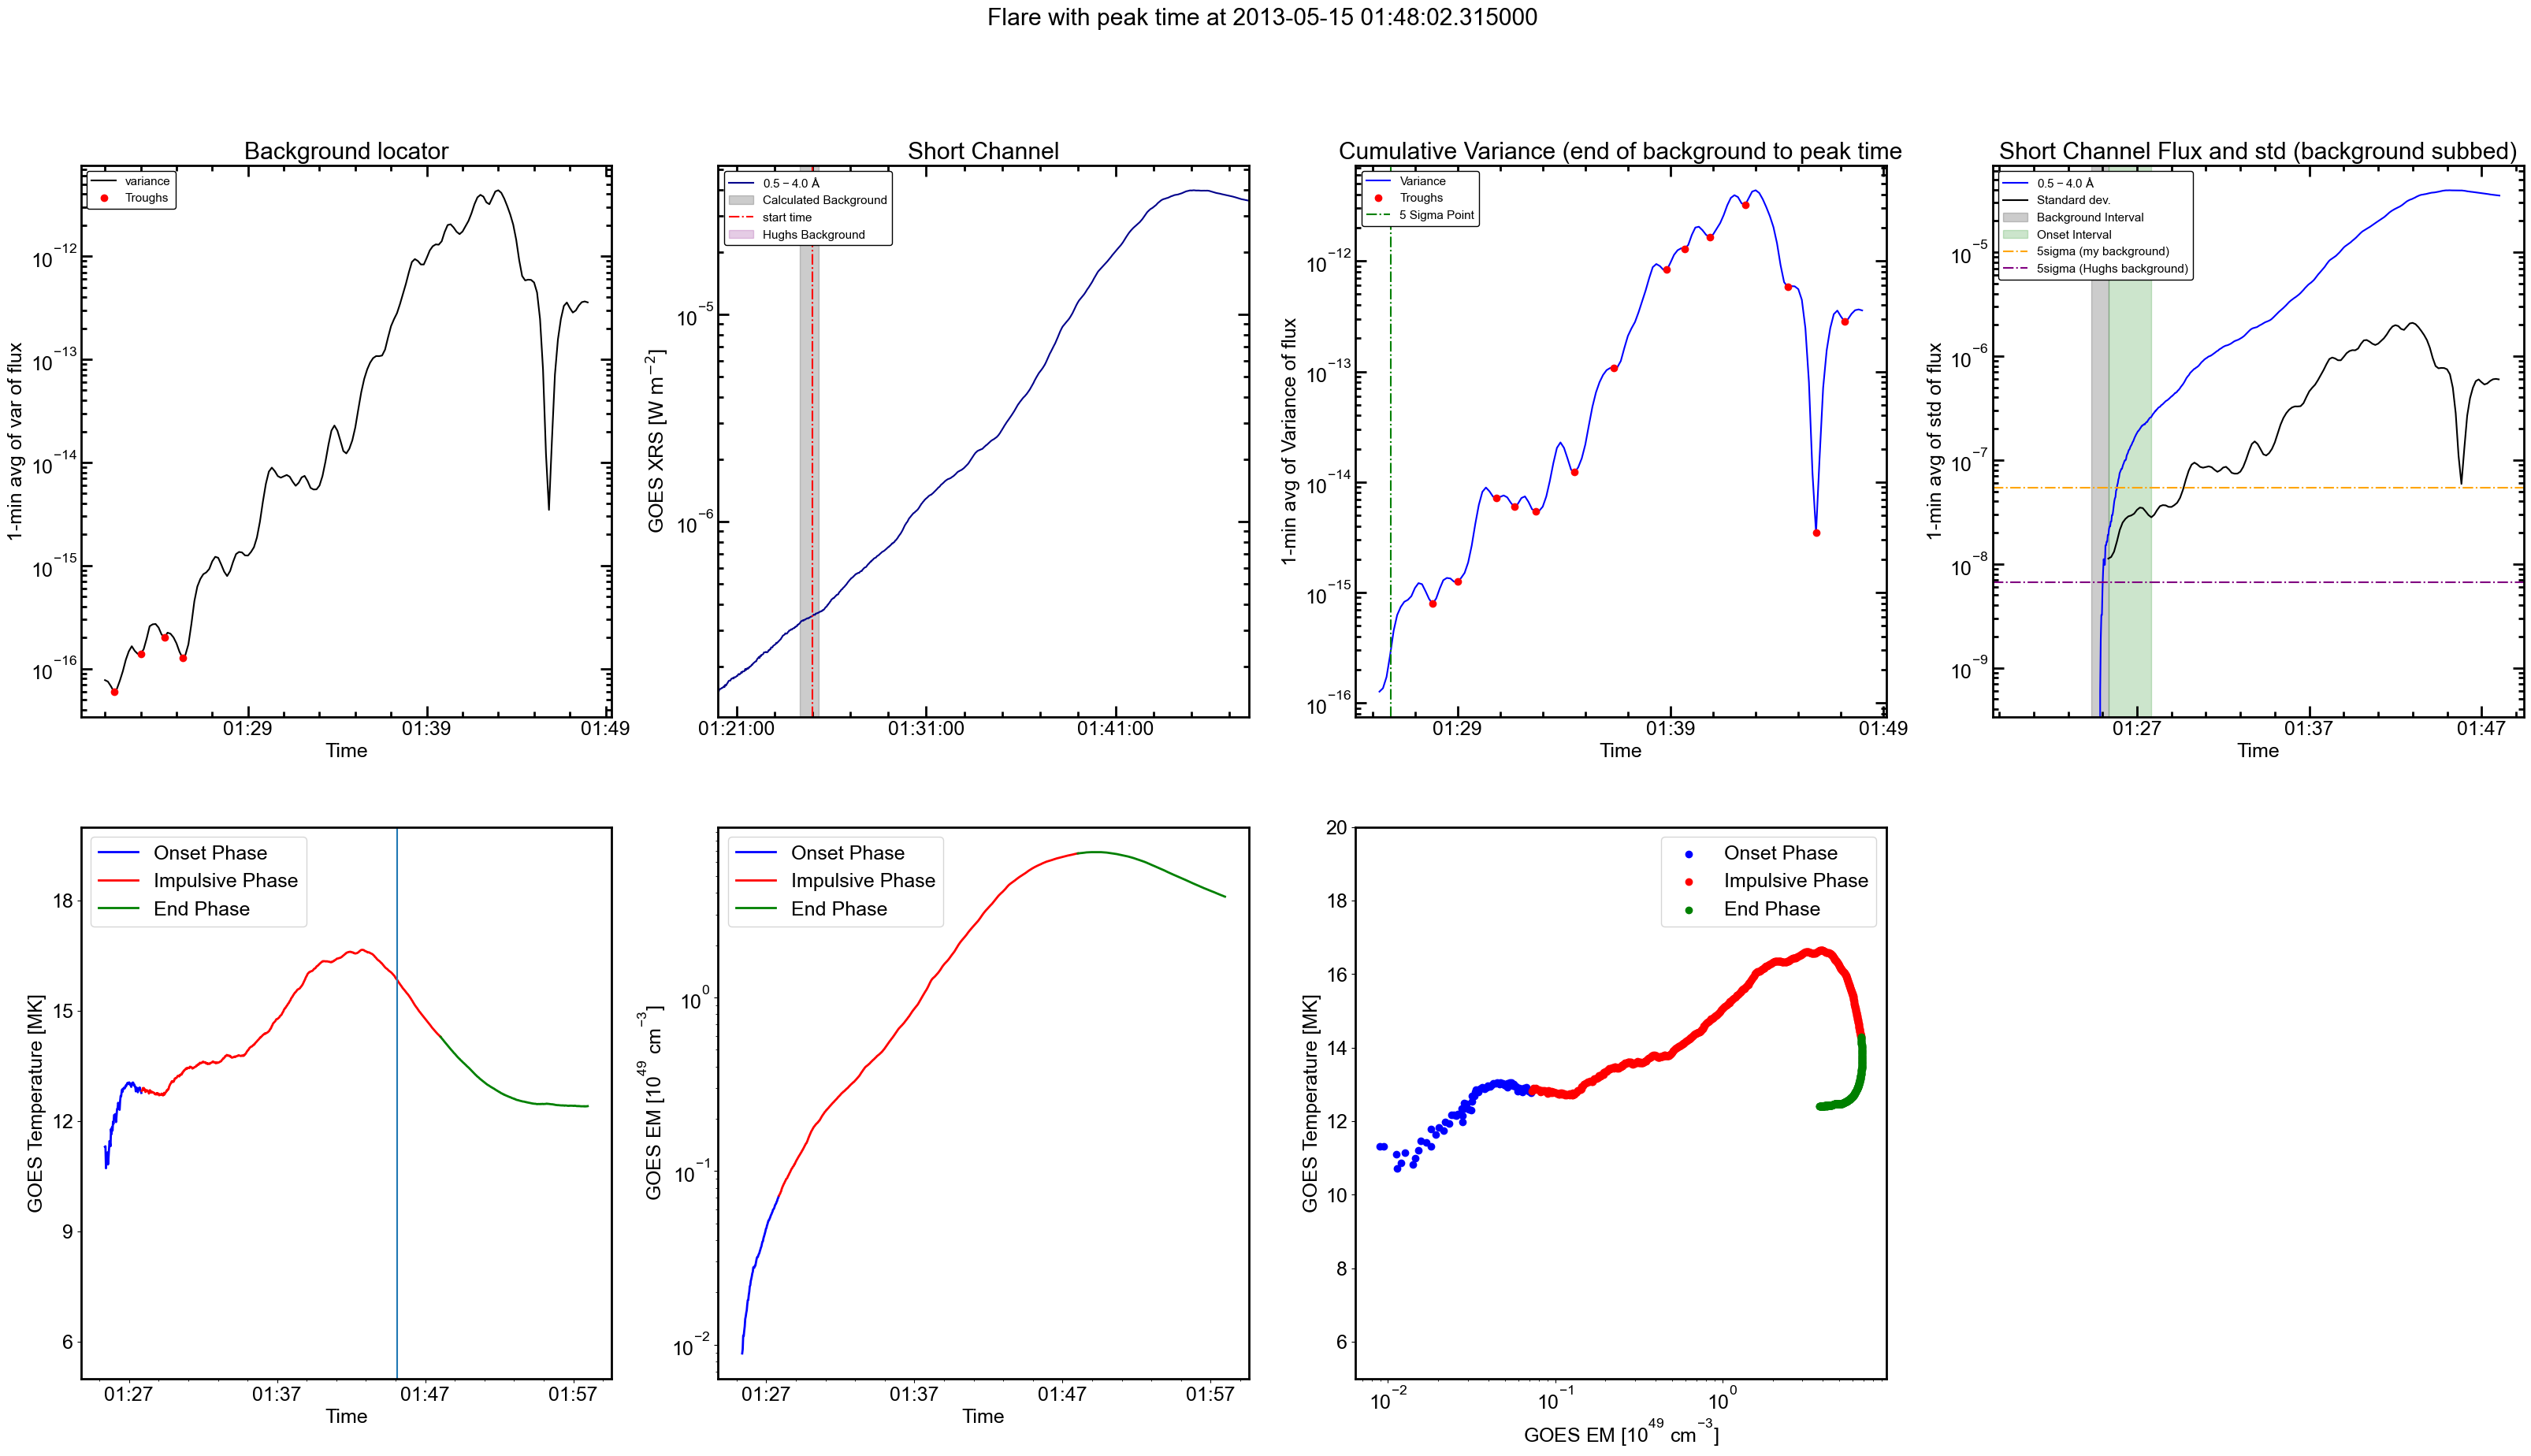


---------Background Time Information---------
Our background timings are between: 2013-06-21 02:25:40 and 2013-06-21 02:26:40
The paper's used backgrounds are 2013-06-21 02:30:44 and 2013-06-21 02:32:26

Our calculated backgrounds are: -3.019e-09 for the short channel and 6.506e-07 for the long channel
The Paper's used backgrounds are: 1.419e-09 for the short channel and 6.836e-07 for the long channel


---------Peak time Information---------
Given peak is: 2013-06-21 03:00:00
Non-backsubbed long channel peak is: 2013-06-21 03:14:54.531000
backsubbed Short channel peak is: 2013-06-21 03:14:54.531000


---------Onset Time Information---------
The start of the onset is calculated to be: 2013-06-21 02:27:40
The end of the onset is calculated to be: 2013-06-21 02:28:20

Mean T during onset: nan MK
Mean EM during onset: nan cm^-3



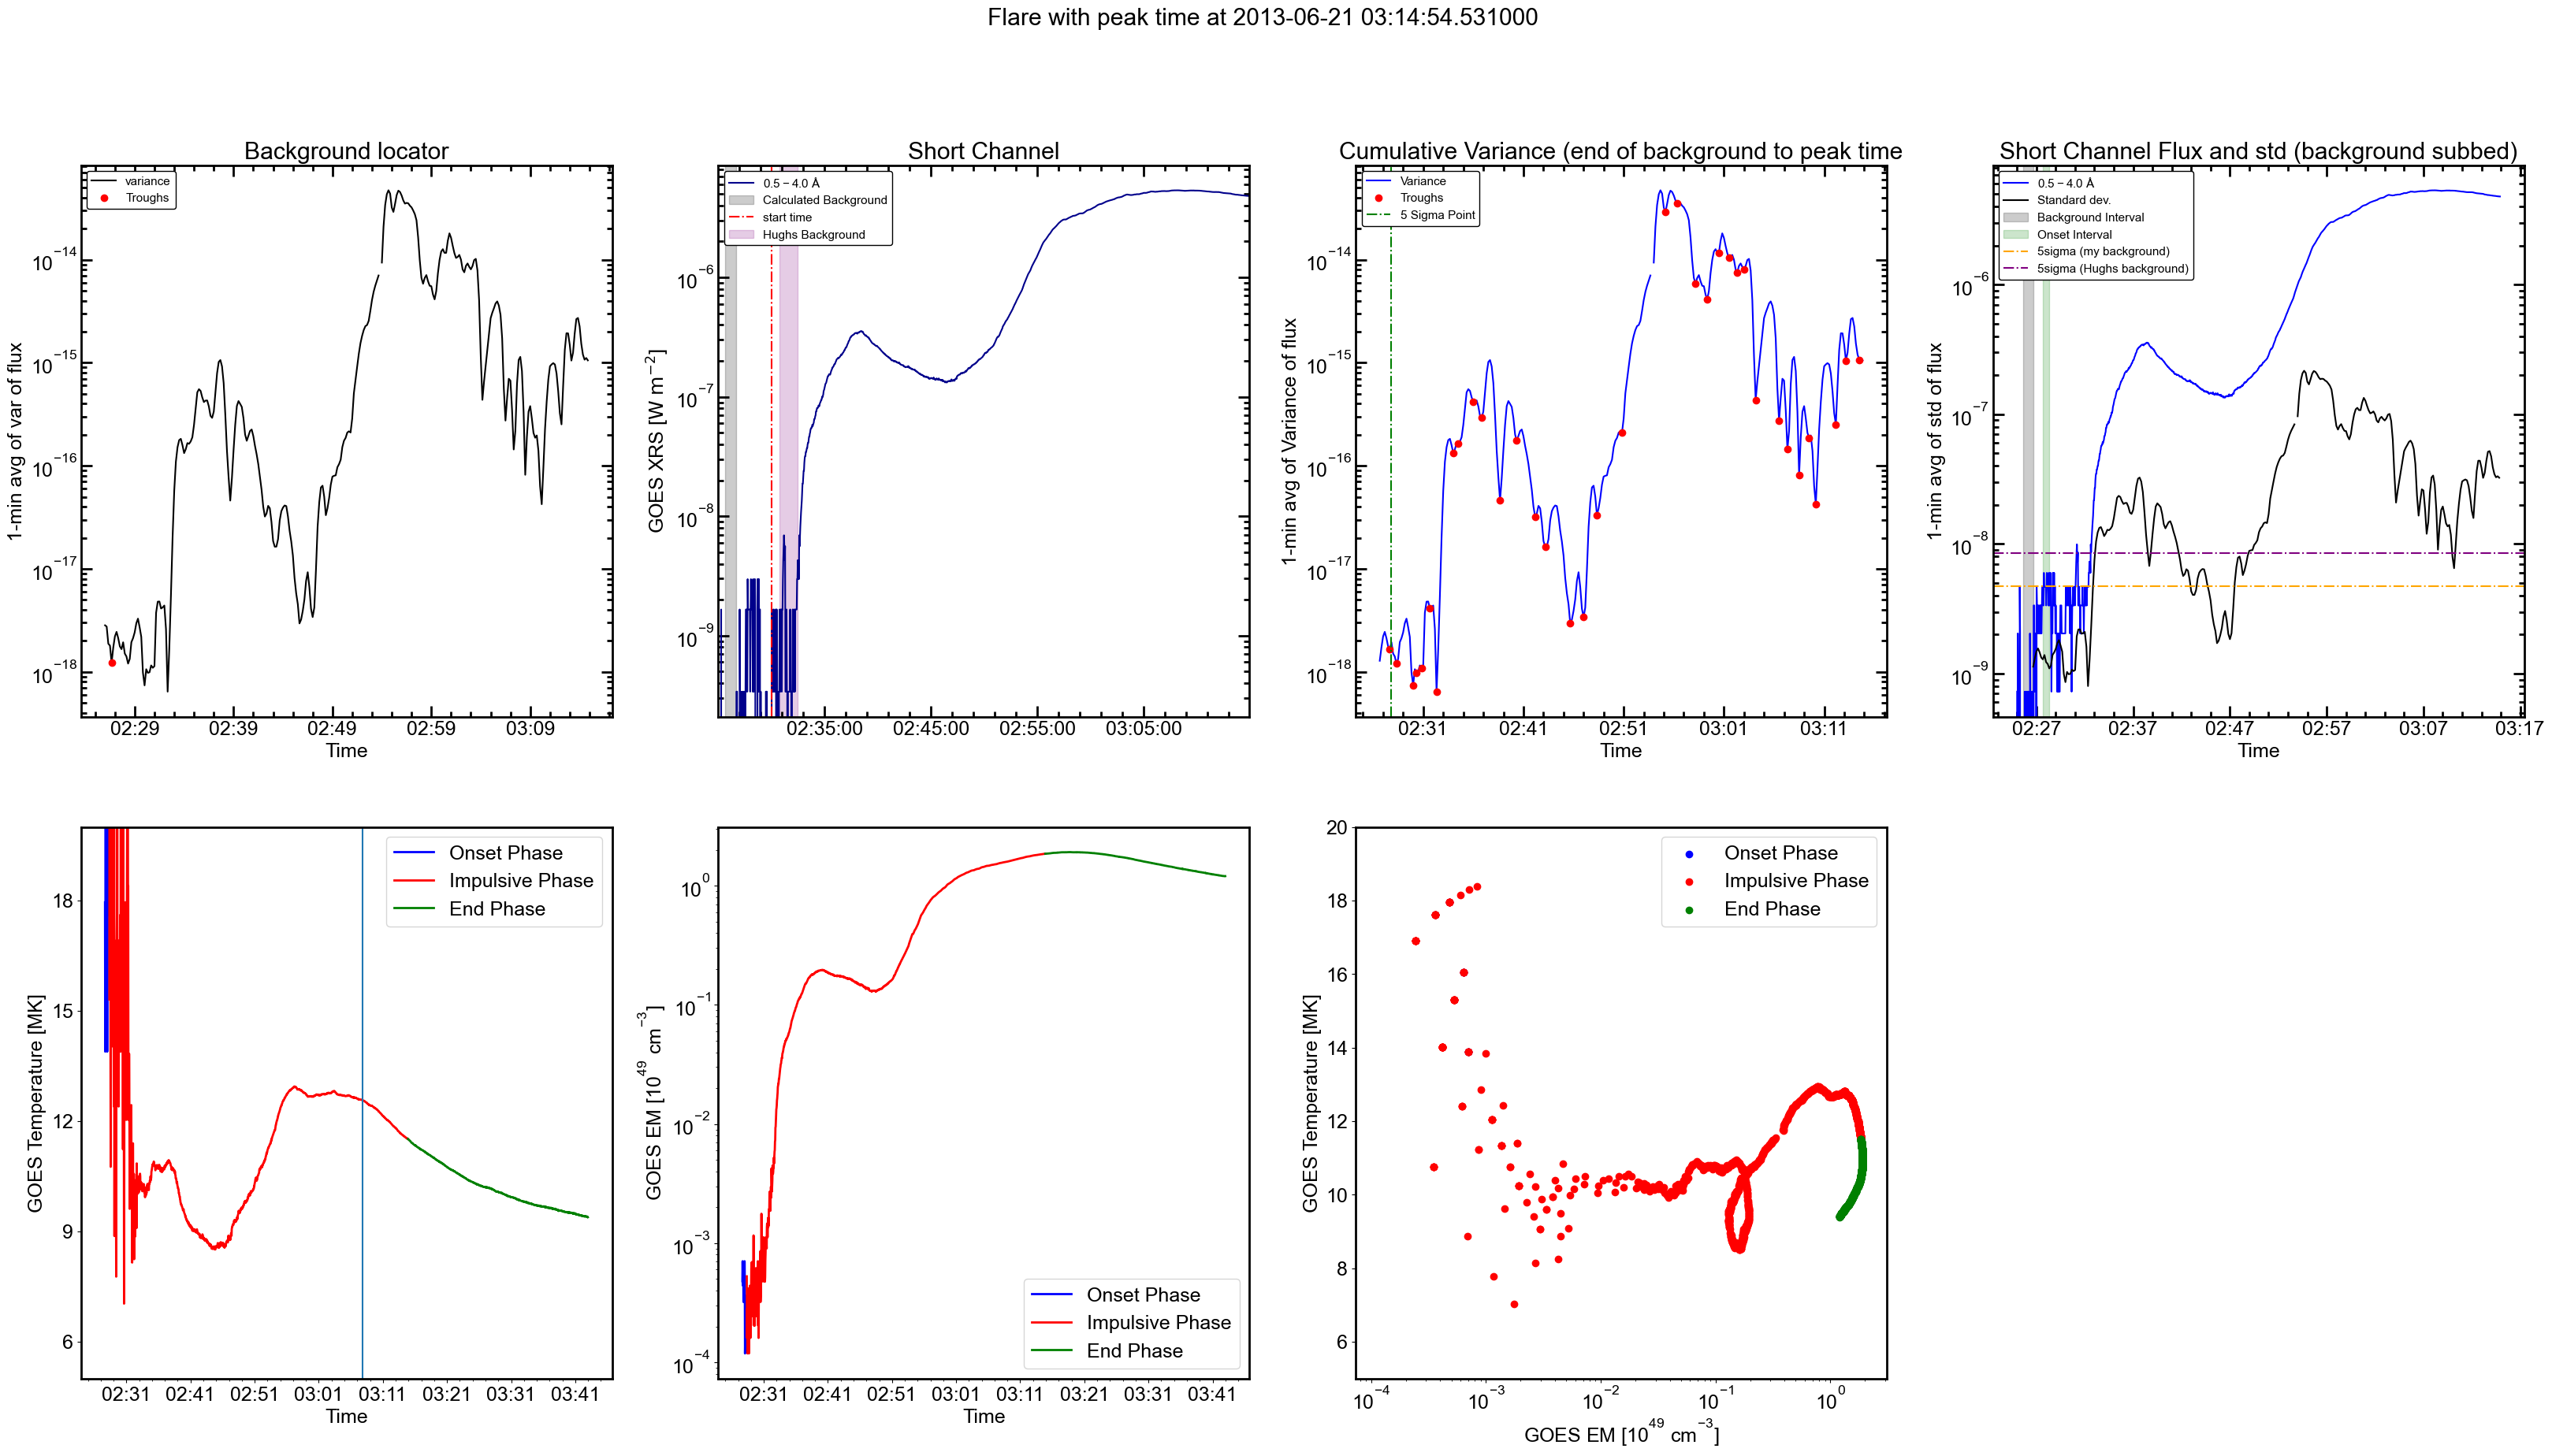


---------Background Time Information---------
Our background timings are between: 2013-10-13 00:03:10 and 2013-10-13 00:04:10
The paper's used backgrounds are 2013-10-12 23:50:32 and 2013-10-12 23:52:15

Our calculated backgrounds are: 1.429e-08 for the short channel and 9.429e-07 for the long channel
The Paper's used backgrounds are: nan for the short channel and nan for the long channel


---------Peak time Information---------
Given peak is: 2013-10-13 00:08:00
Non-backsubbed long channel peak is: 2013-10-13 00:08:40.471000
backsubbed Short channel peak is: 2013-10-13 00:08:40.471000


Not enough troughs located!
Going to caculate the onset time to be 1 minute after the background.

---------Onset Time Information---------
The start of the onset is calculated to be: 2013-10-13 00:04:12
The end of the onset is calculated to be: 2013-10-13 00:05:10

Mean T during onset: 6.93 MK
Mean EM during onset: 1.69e+47 cm^-3



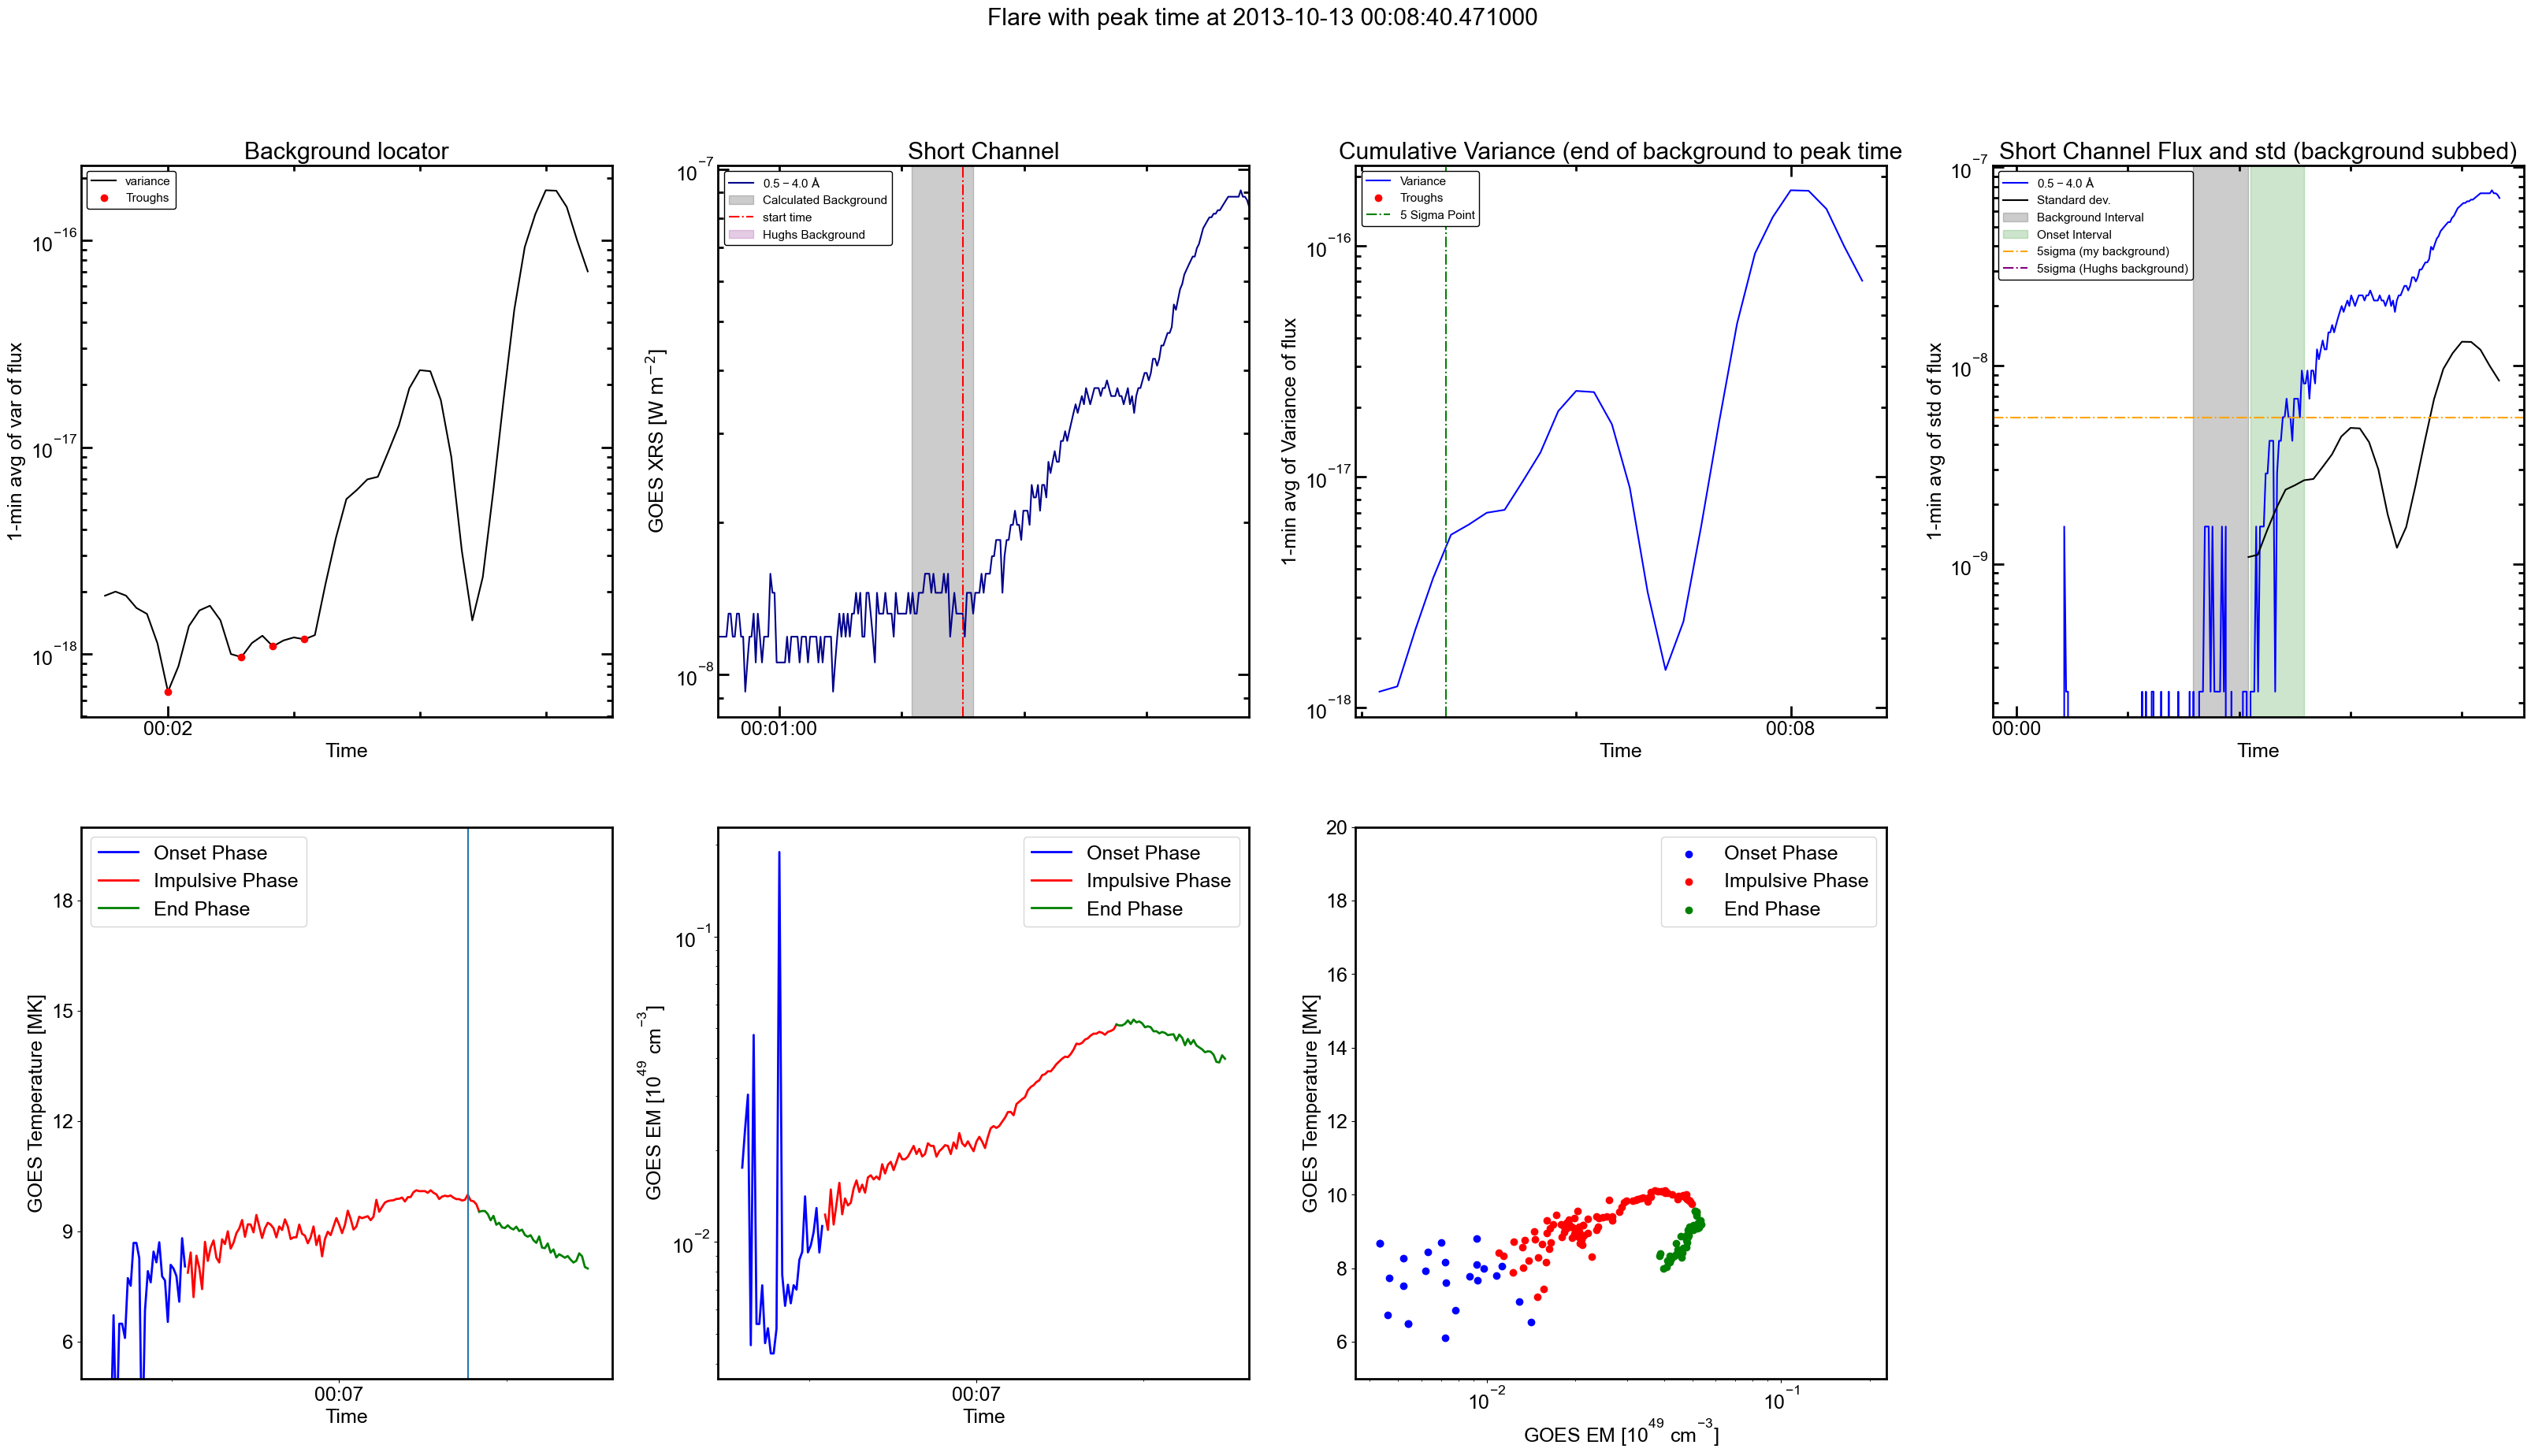


---------Background Time Information---------
Our background timings are between: 2013-10-28 11:29:00 and 2013-10-28 11:30:00
The paper's used backgrounds are 2013-10-28 11:19:05 and 2013-10-28 11:20:48

Our calculated backgrounds are: 9.931e-08 for the short channel and 3.034e-06 for the long channel
The Paper's used backgrounds are: 4.219e-08 for the short channel and 2.312e-06 for the long channel


---------Peak time Information---------
Given peak is: 2013-10-28 11:53:00
Non-backsubbed long channel peak is: 2013-10-28 11:53:01.658000
backsubbed Short channel peak is: 2013-10-28 11:53:01.658000


---------Onset Time Information---------
The start of the onset is calculated to be: 2013-10-28 11:30:02
The end of the onset is calculated to be: 2013-10-28 11:32:30

Mean T during onset: 9.17 MK
Mean EM during onset: 1.97e+47 cm^-3



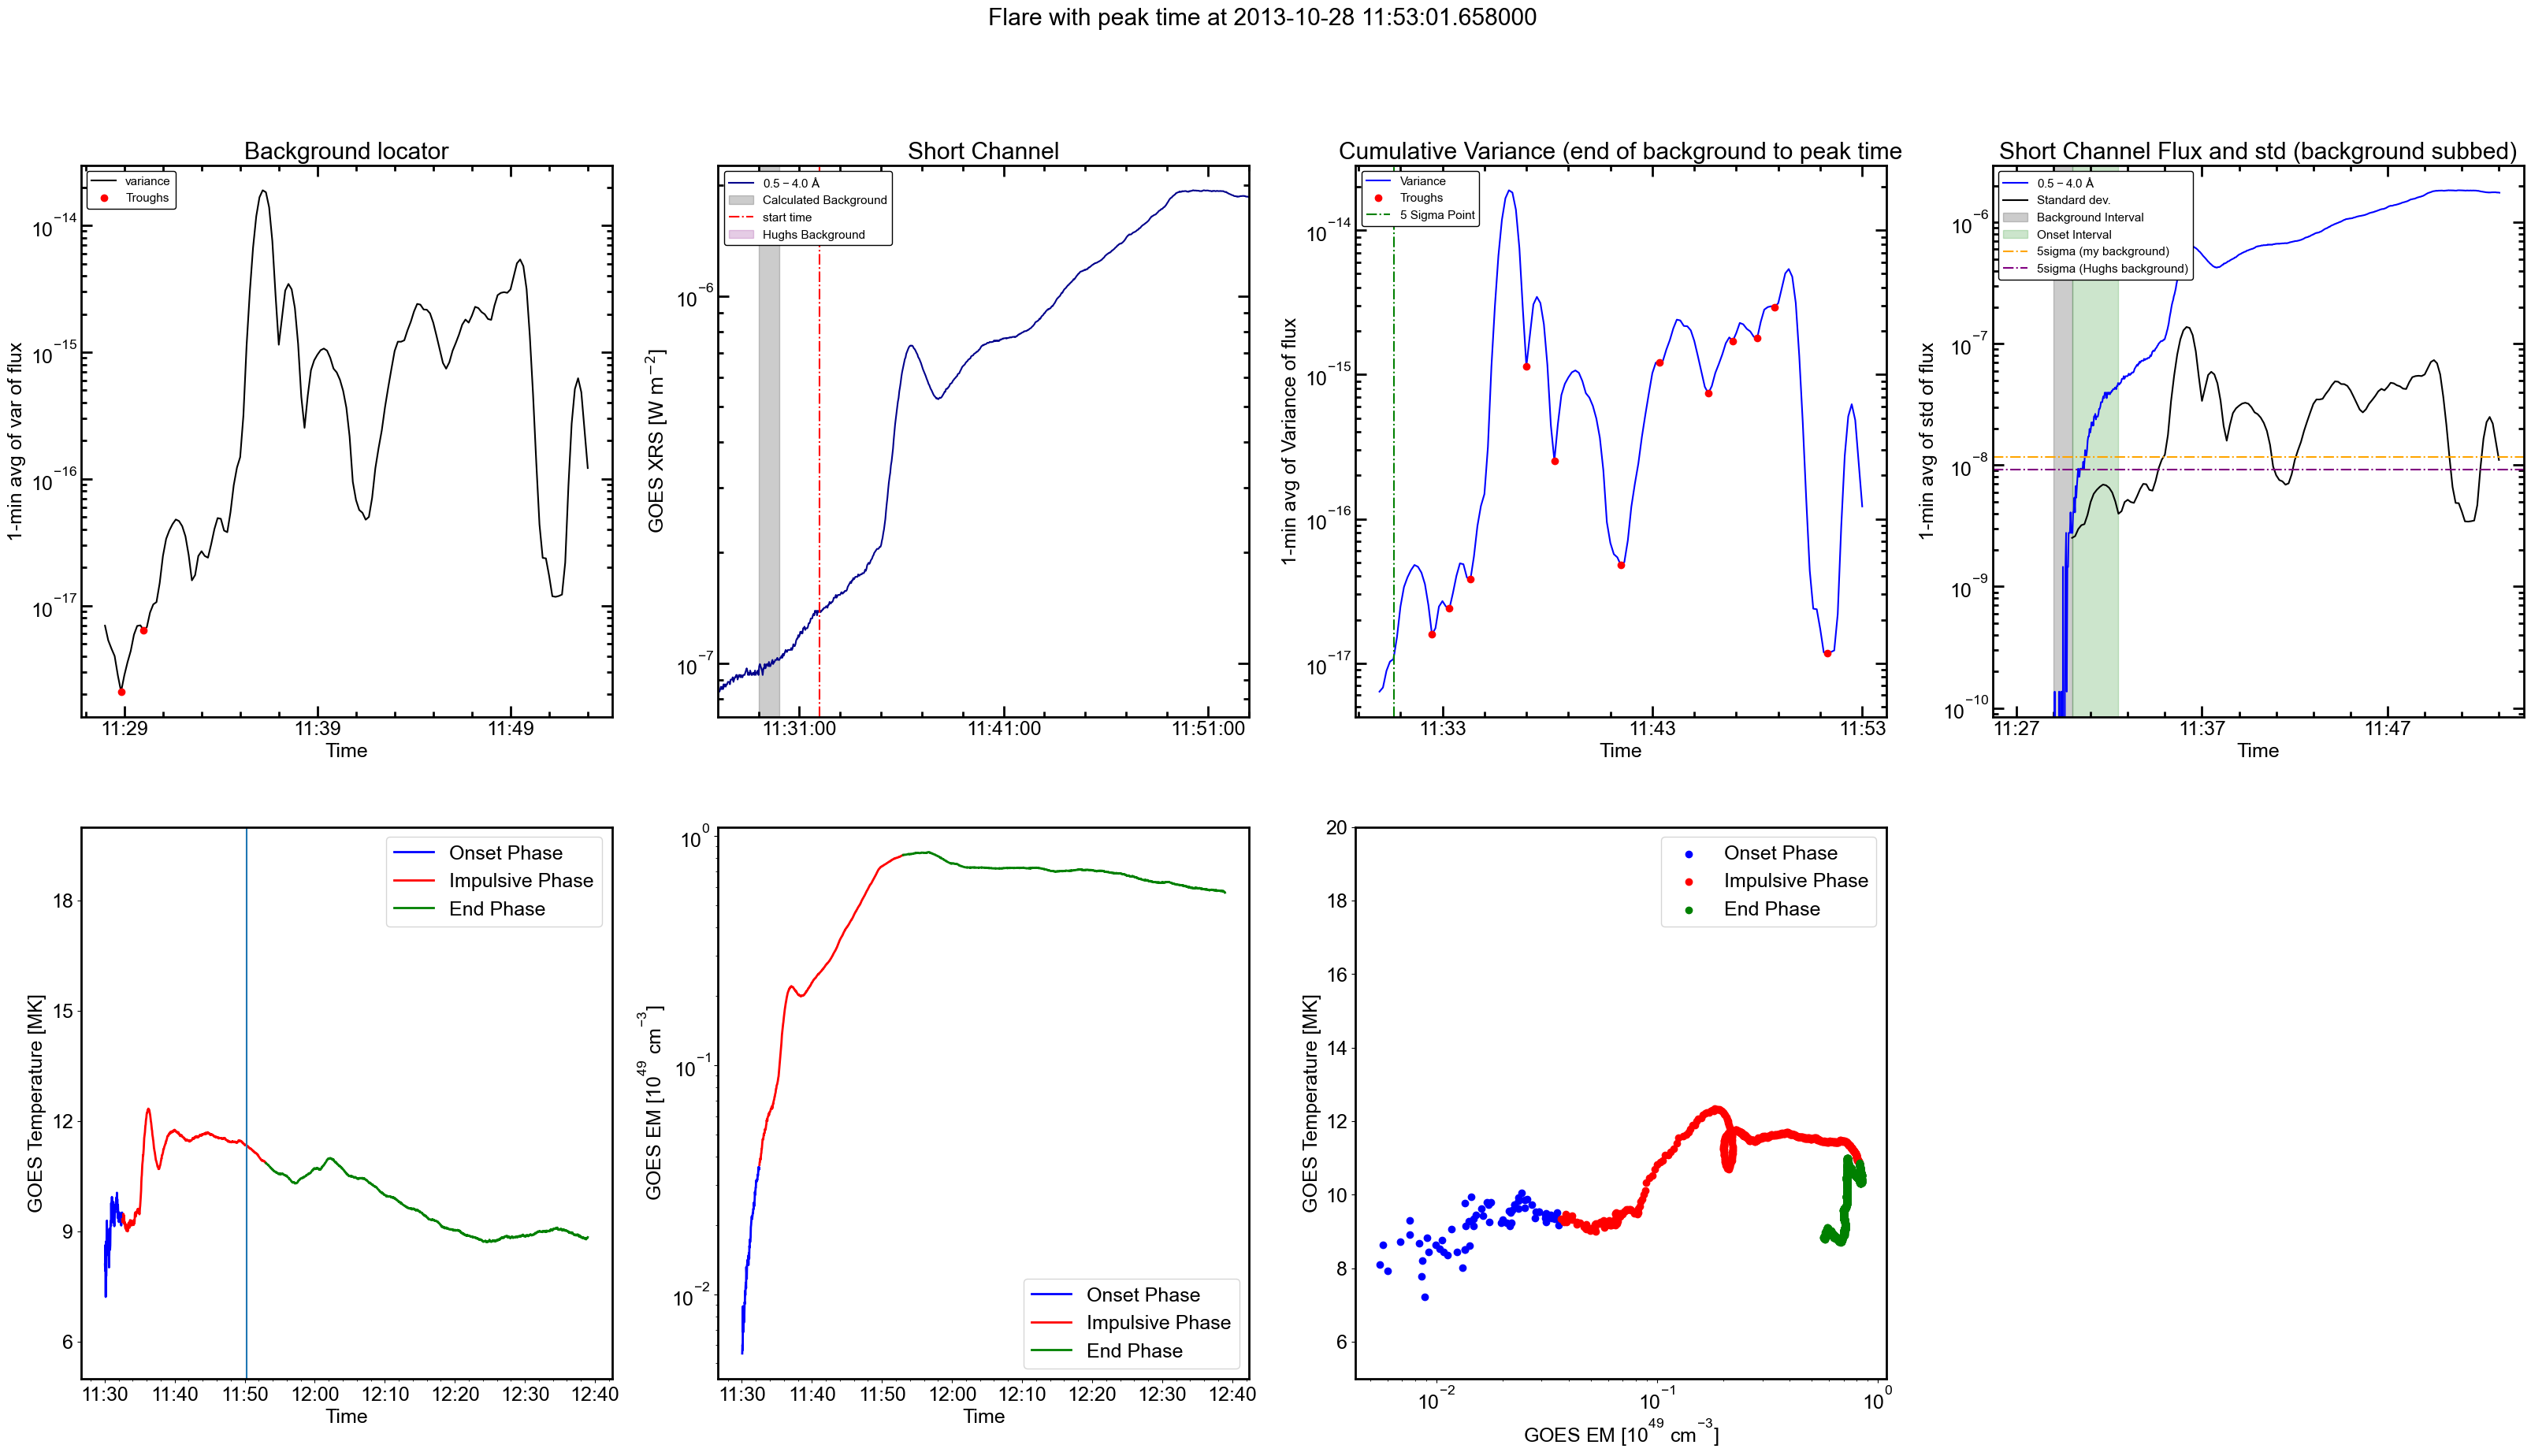


---------Background Time Information---------
Our background timings are between: 2013-12-20 11:30:40 and 2013-12-20 11:31:40
The paper's used backgrounds are 2013-12-20 11:27:42 and 2013-12-20 11:29:24

Our calculated backgrounds are: 5.144e-08 for the short channel and 2.224e-06 for the long channel
The Paper's used backgrounds are: 4.816e-08 for the short channel and 2.146e-06 for the long channel


---------Peak time Information---------
Given peak is: 2013-12-20 11:57:00
Non-backsubbed long channel peak is: 2013-12-20 11:57:20.048000
backsubbed Short channel peak is: 2013-12-20 11:57:20.048000


---------Onset Time Information---------
The start of the onset is calculated to be: 2013-12-20 11:31:42
The end of the onset is calculated to be: 2013-12-20 11:32:50

Mean T during onset: 12.87 MK
Mean EM during onset: 1.55e+46 cm^-3



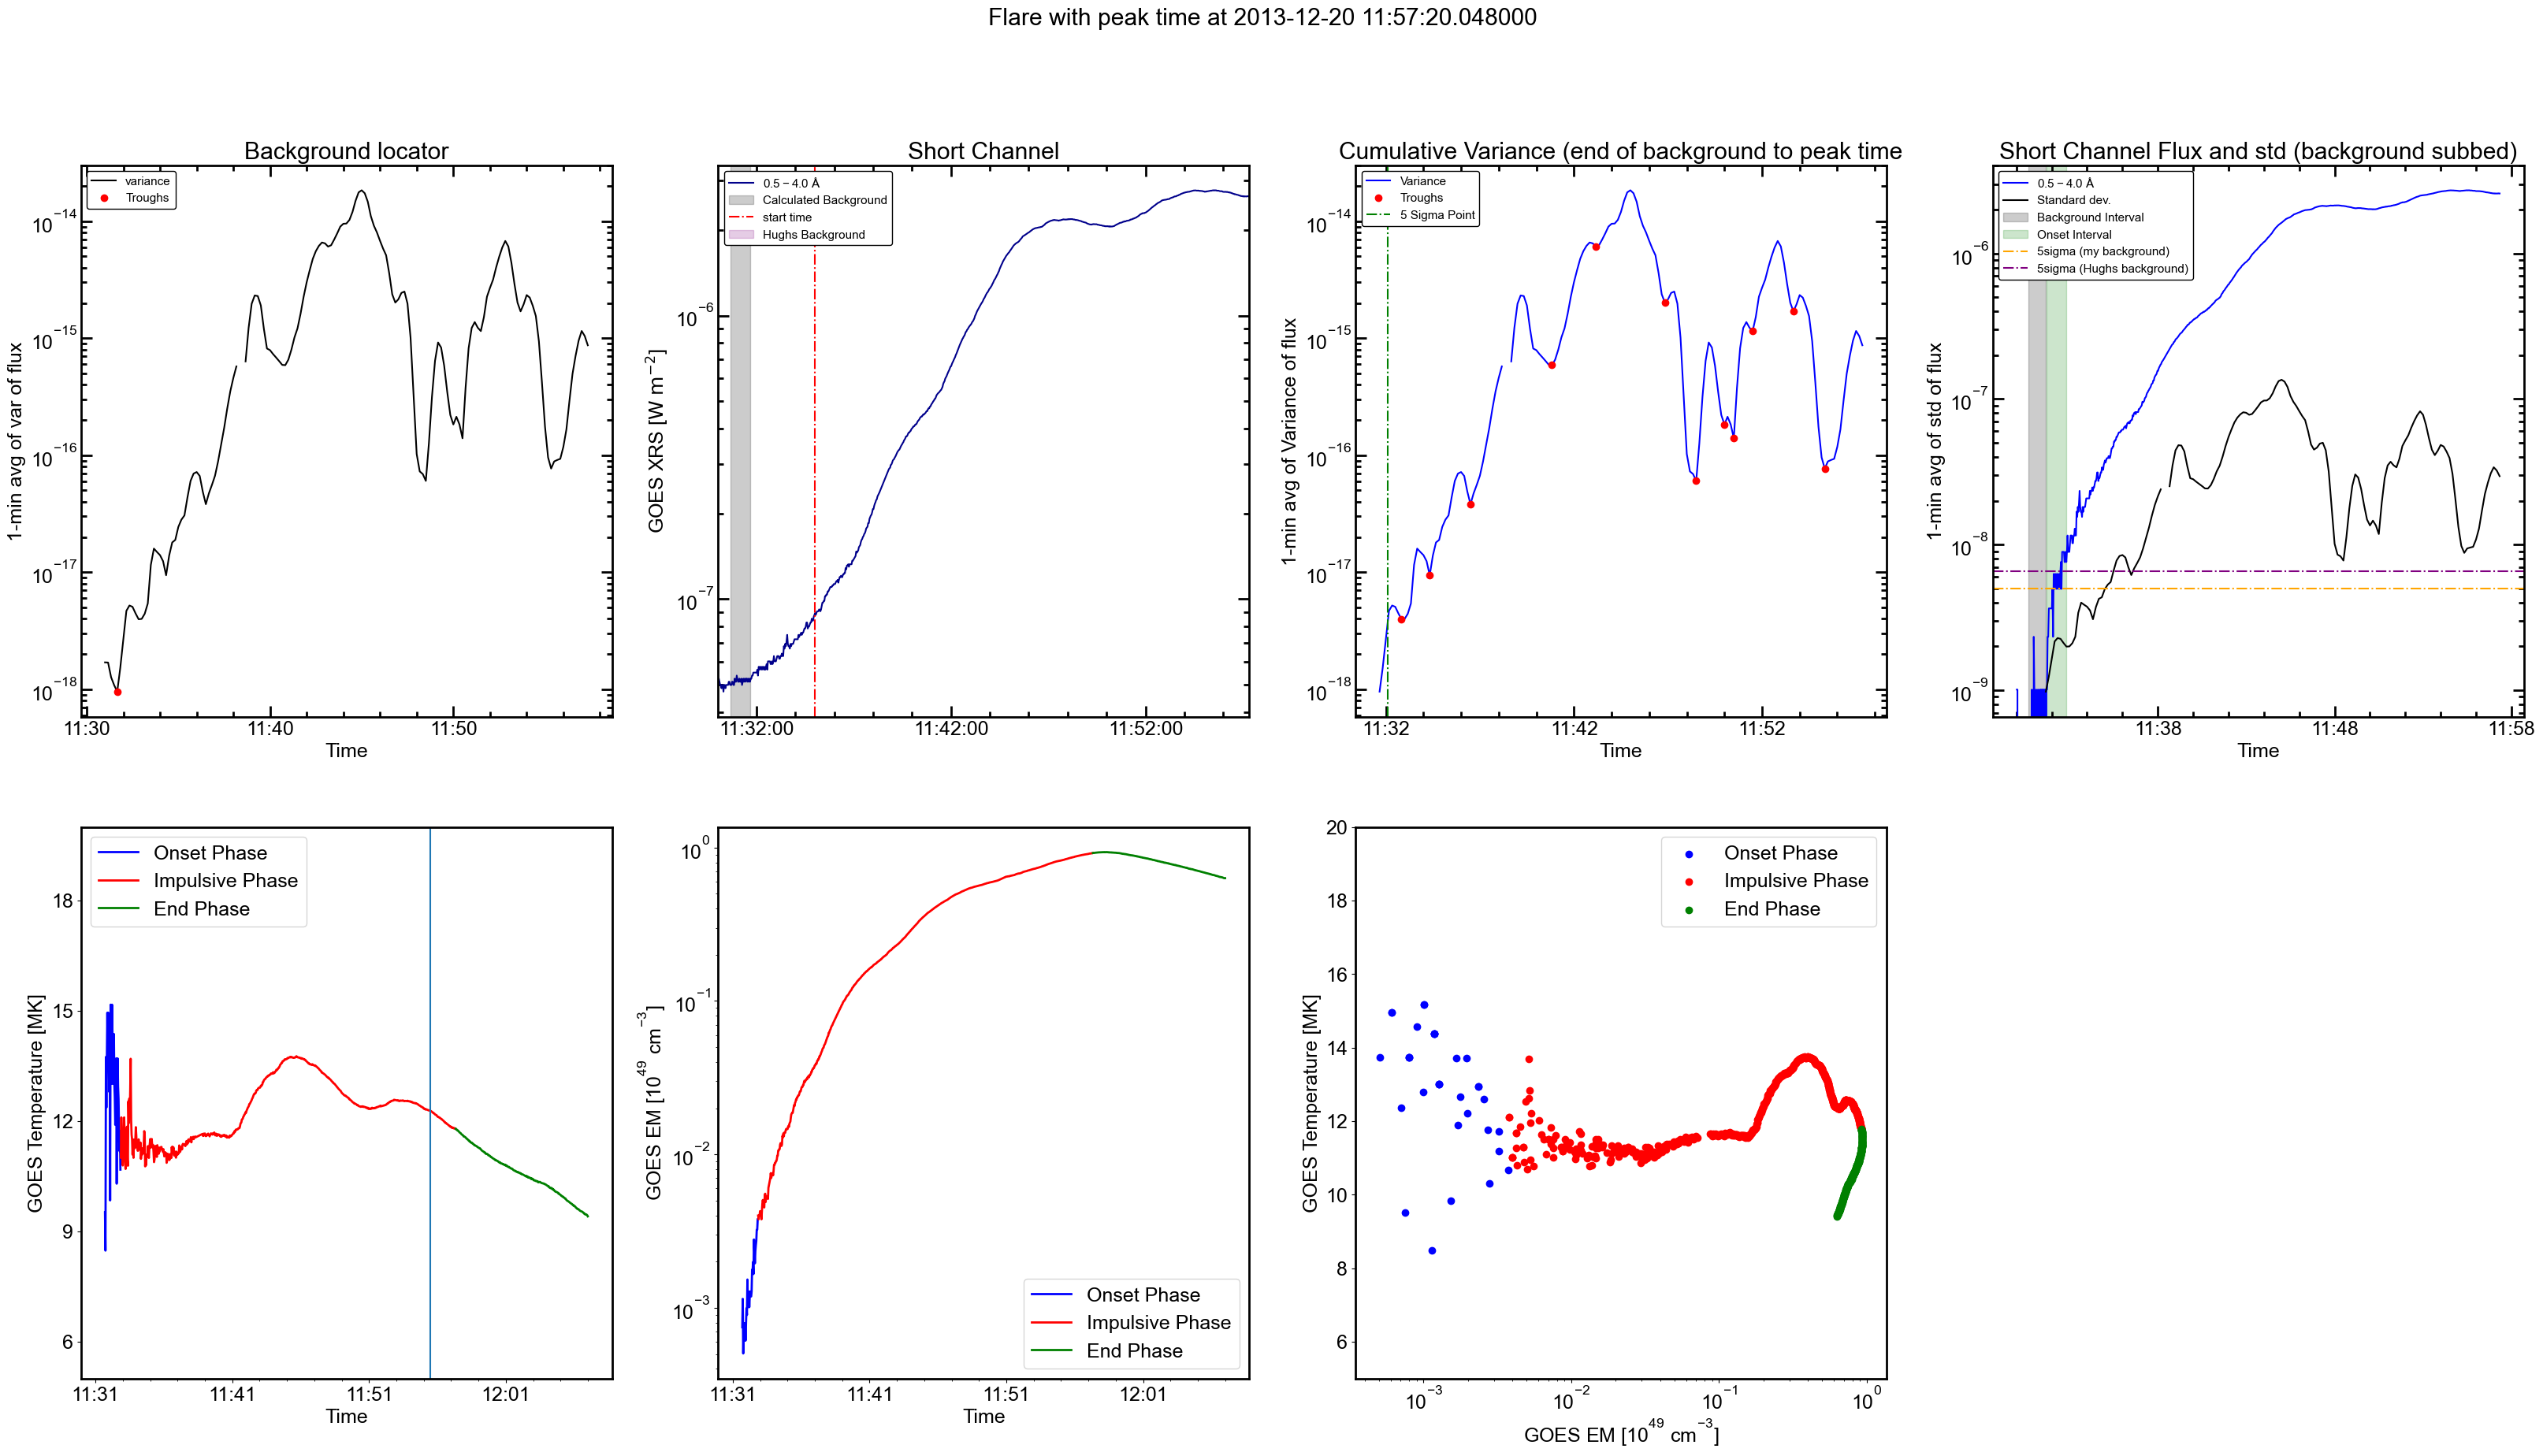


---------Background Time Information---------
Our background timings are between: 2013-12-22 11:18:10 and 2013-12-22 11:19:10
The paper's used backgrounds are 2013-12-22 11:13:48 and 2013-12-22 11:15:30

Our calculated backgrounds are: 1.898e-08 for the short channel and 1.302e-06 for the long channel
The Paper's used backgrounds are: 1.307e-08 for the short channel and 1.272e-06 for the long channel


---------Peak time Information---------
Given peak is: 2013-12-22 11:26:00
Non-backsubbed long channel peak is: 2013-12-22 11:25:59.315000
backsubbed Short channel peak is: 2013-12-22 11:25:59.315000


Not enough troughs located!
Going to caculate the onset time to be 1 minute after the background.

---------Onset Time Information---------
The start of the onset is calculated to be: 2013-12-22 11:19:12
The end of the onset is calculated to be: 2013-12-22 11:20:10

Mean T during onset: 10.20 MK
Mean EM during onset: 2.83e+46 cm^-3



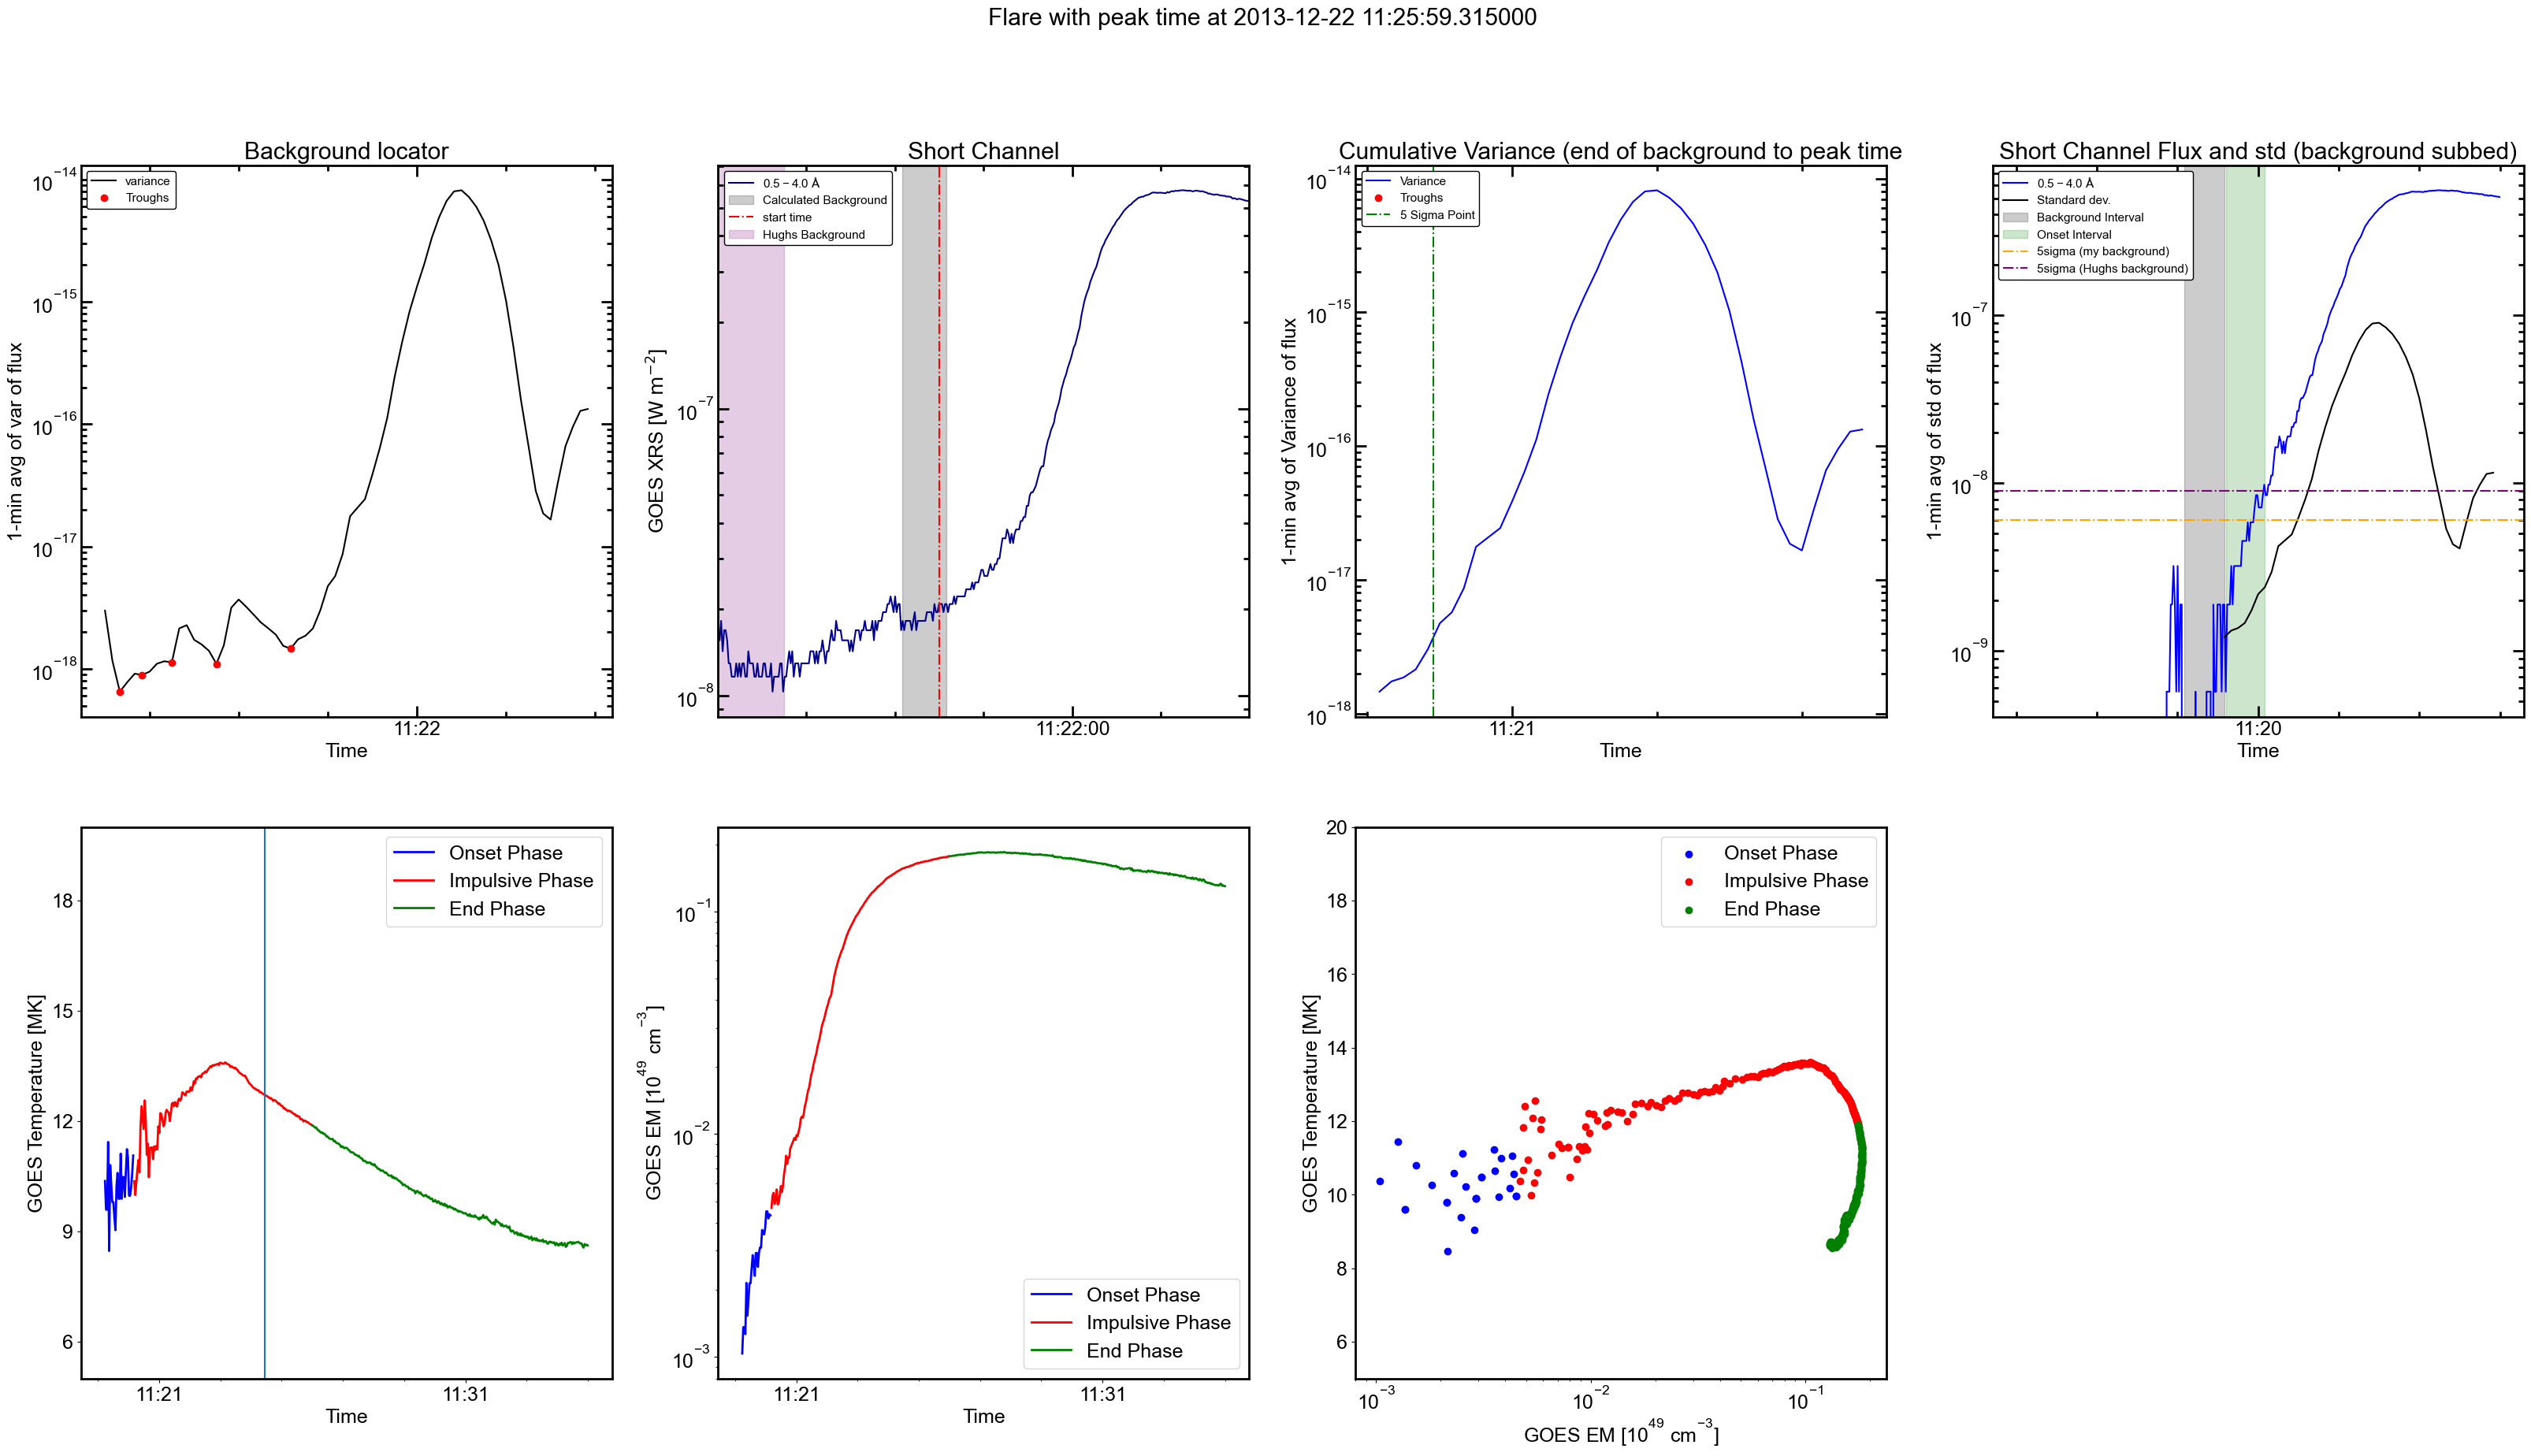

---------------------
No Suitable Background Detected... Using a 1 min window starting from start time
---------------------

---------Background Time Information---------
Our background timings are between: 2014-02-11 03:22:00.000 and 2014-02-11 03:23:00.000
The paper's used backgrounds are 2014-02-11 03:04:24 and 2014-02-11 03:06:07

Our calculated backgrounds are: 2.591e-07 for the short channel and 4.447e-06 for the long channel
The Paper's used backgrounds are: 3.501e-08 for the short channel and 1.977e-06 for the long channel


---------Peak time Information---------
Given peak is: 2014-02-11 03:31:00
Non-backsubbed long channel peak is: 2014-02-11 03:31:06.405000
backsubbed Short channel peak is: 2014-02-11 03:31:06.405000


Not enough troughs located!
Going to caculate the onset time to be 1 minute after the background.

---------Onset Time Information---------
The start of the onset is calculated to be: 2014-02-11 03:23:02
The end of the onset is calculated to be: 2014-02-11 0

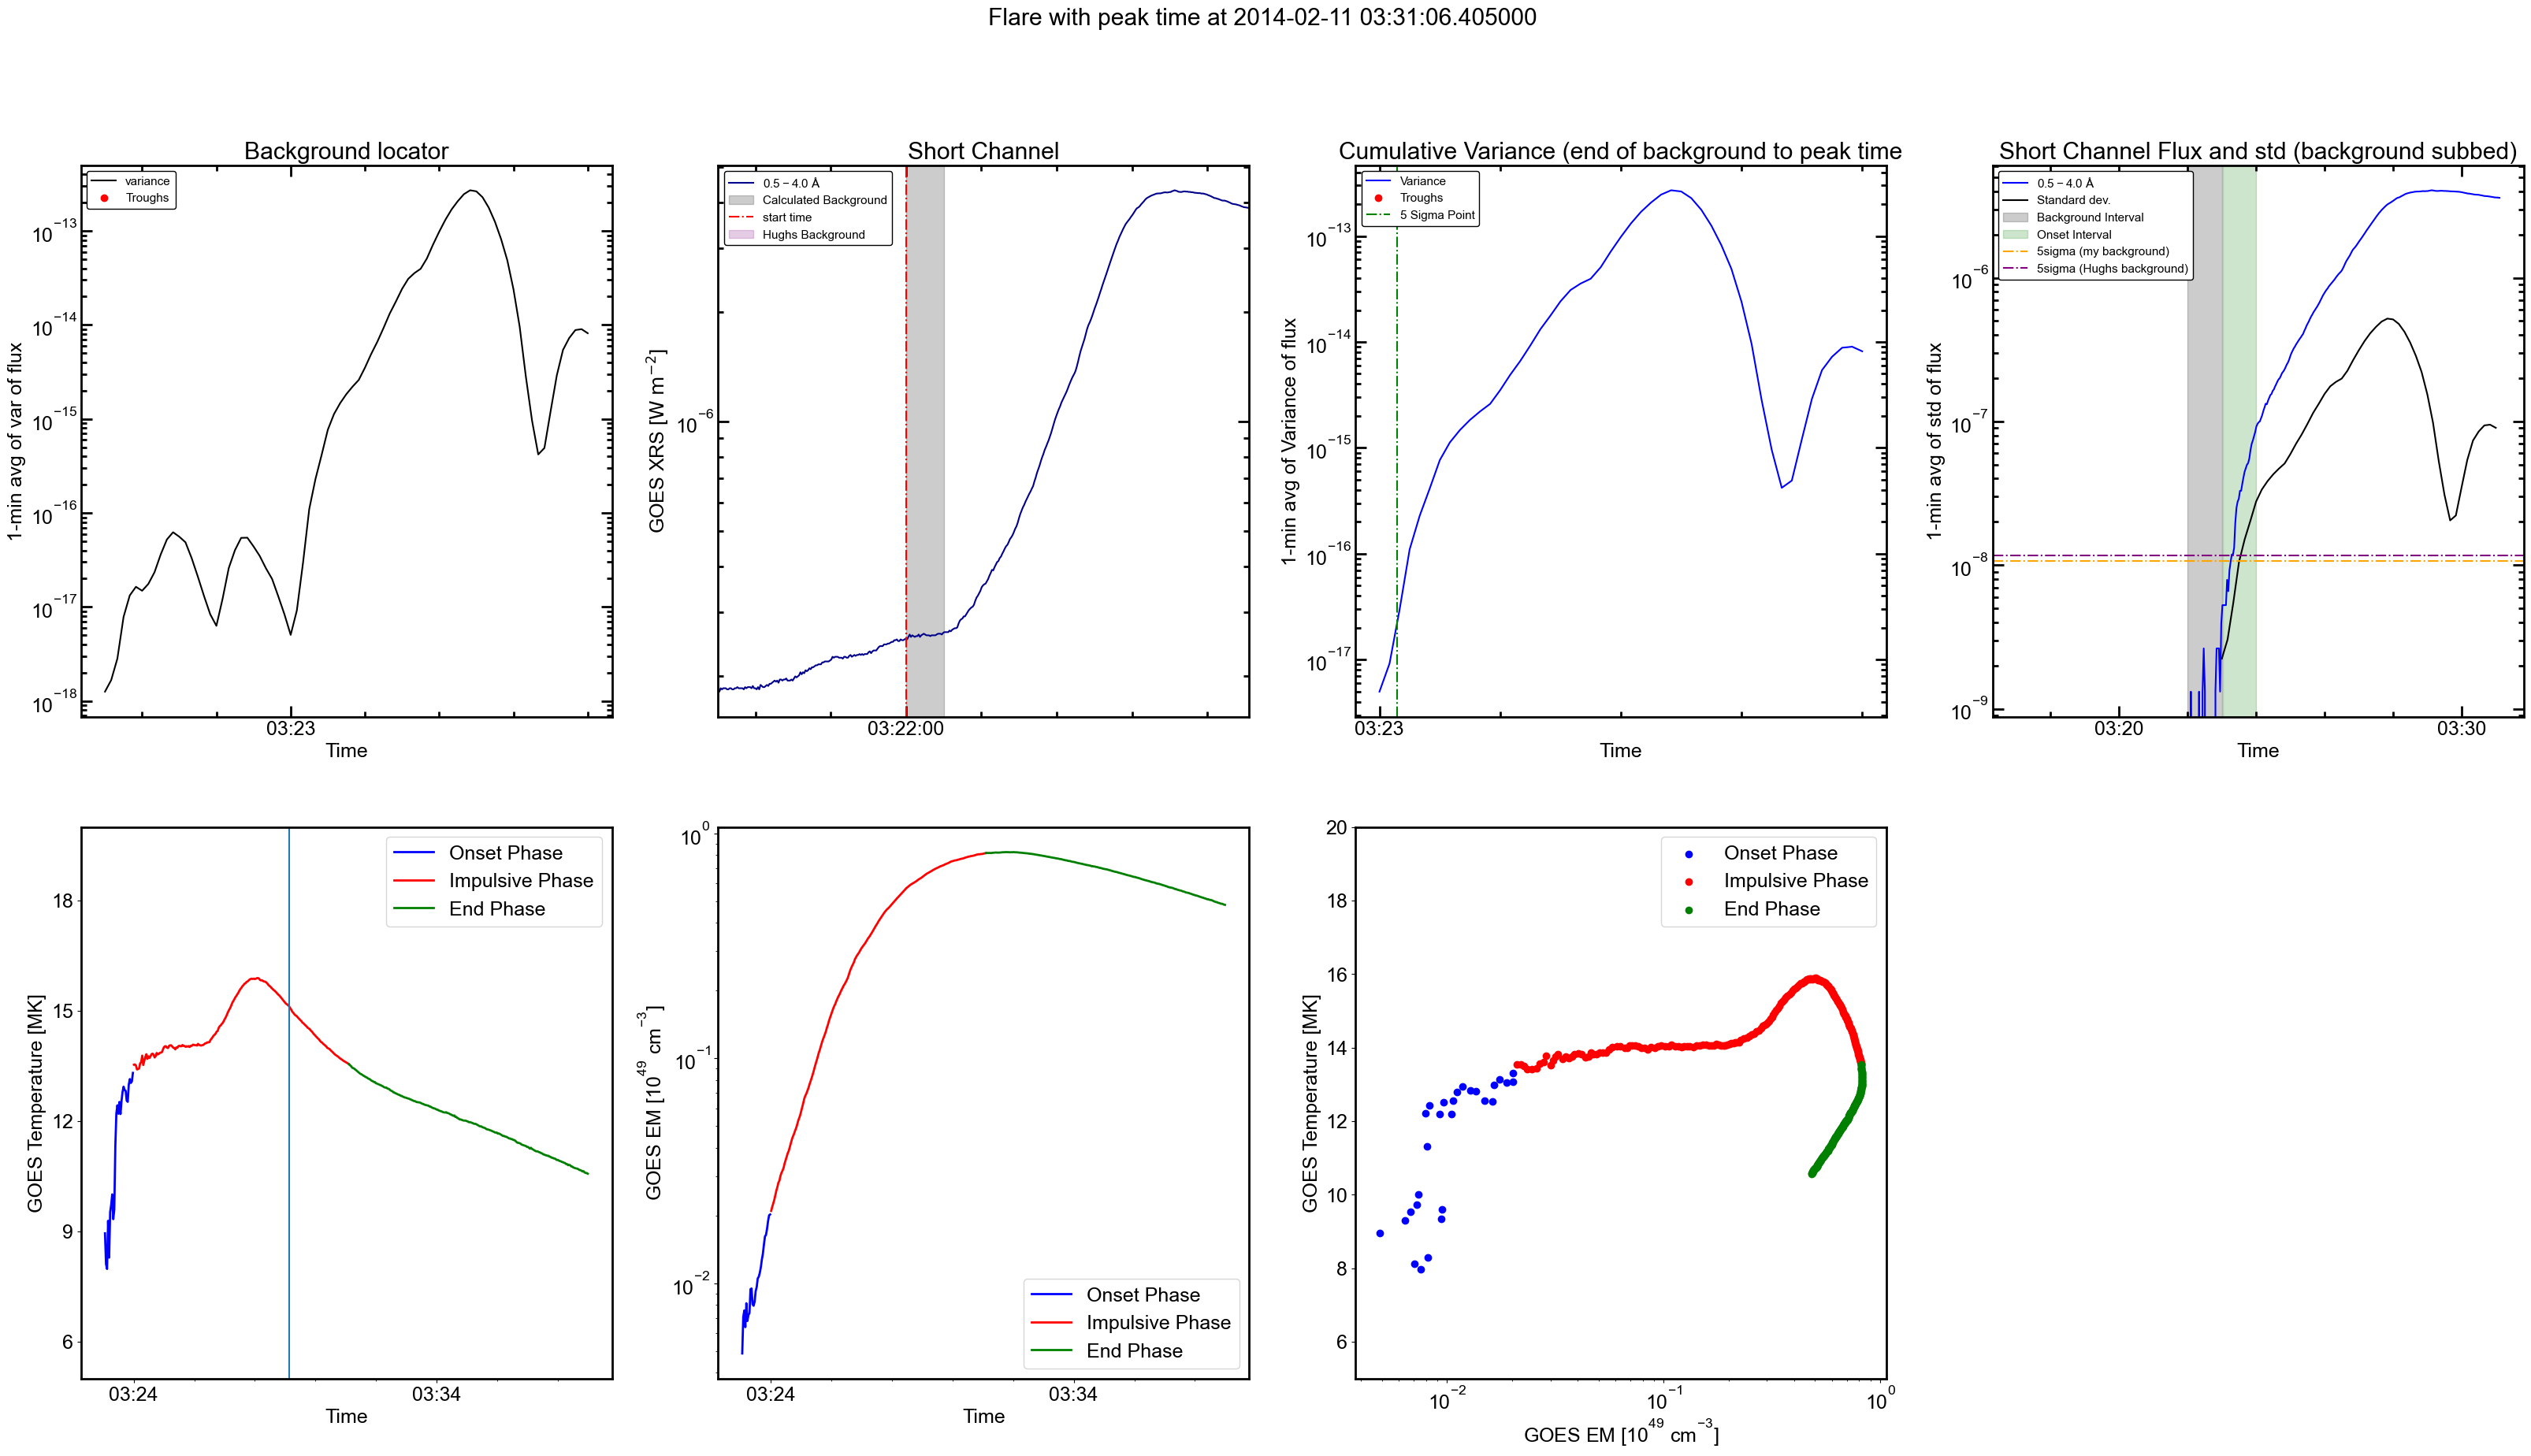


---------Background Time Information---------
Our background timings are between: 2014-02-14 02:35:30 and 2014-02-14 02:36:30
The paper's used backgrounds are 2014-02-14 02:27:01 and 2014-02-14 02:28:43

Our calculated backgrounds are: 9.723e-08 for the short channel and 2.813e-06 for the long channel
The Paper's used backgrounds are: 4.814e-08 for the short channel and 2.045e-06 for the long channel


---------Peak time Information---------
Given peak is: 2014-02-14 02:57:00
Non-backsubbed long channel peak is: 2014-02-14 02:57:07.545000
backsubbed Short channel peak is: 2014-02-14 02:57:07.545000


---------Onset Time Information---------
The start of the onset is calculated to be: 2014-02-14 02:36:32
The end of the onset is calculated to be: 2014-02-14 02:37:40

Mean T during onset: 11.22 MK
Mean EM during onset: 9.82e+46 cm^-3



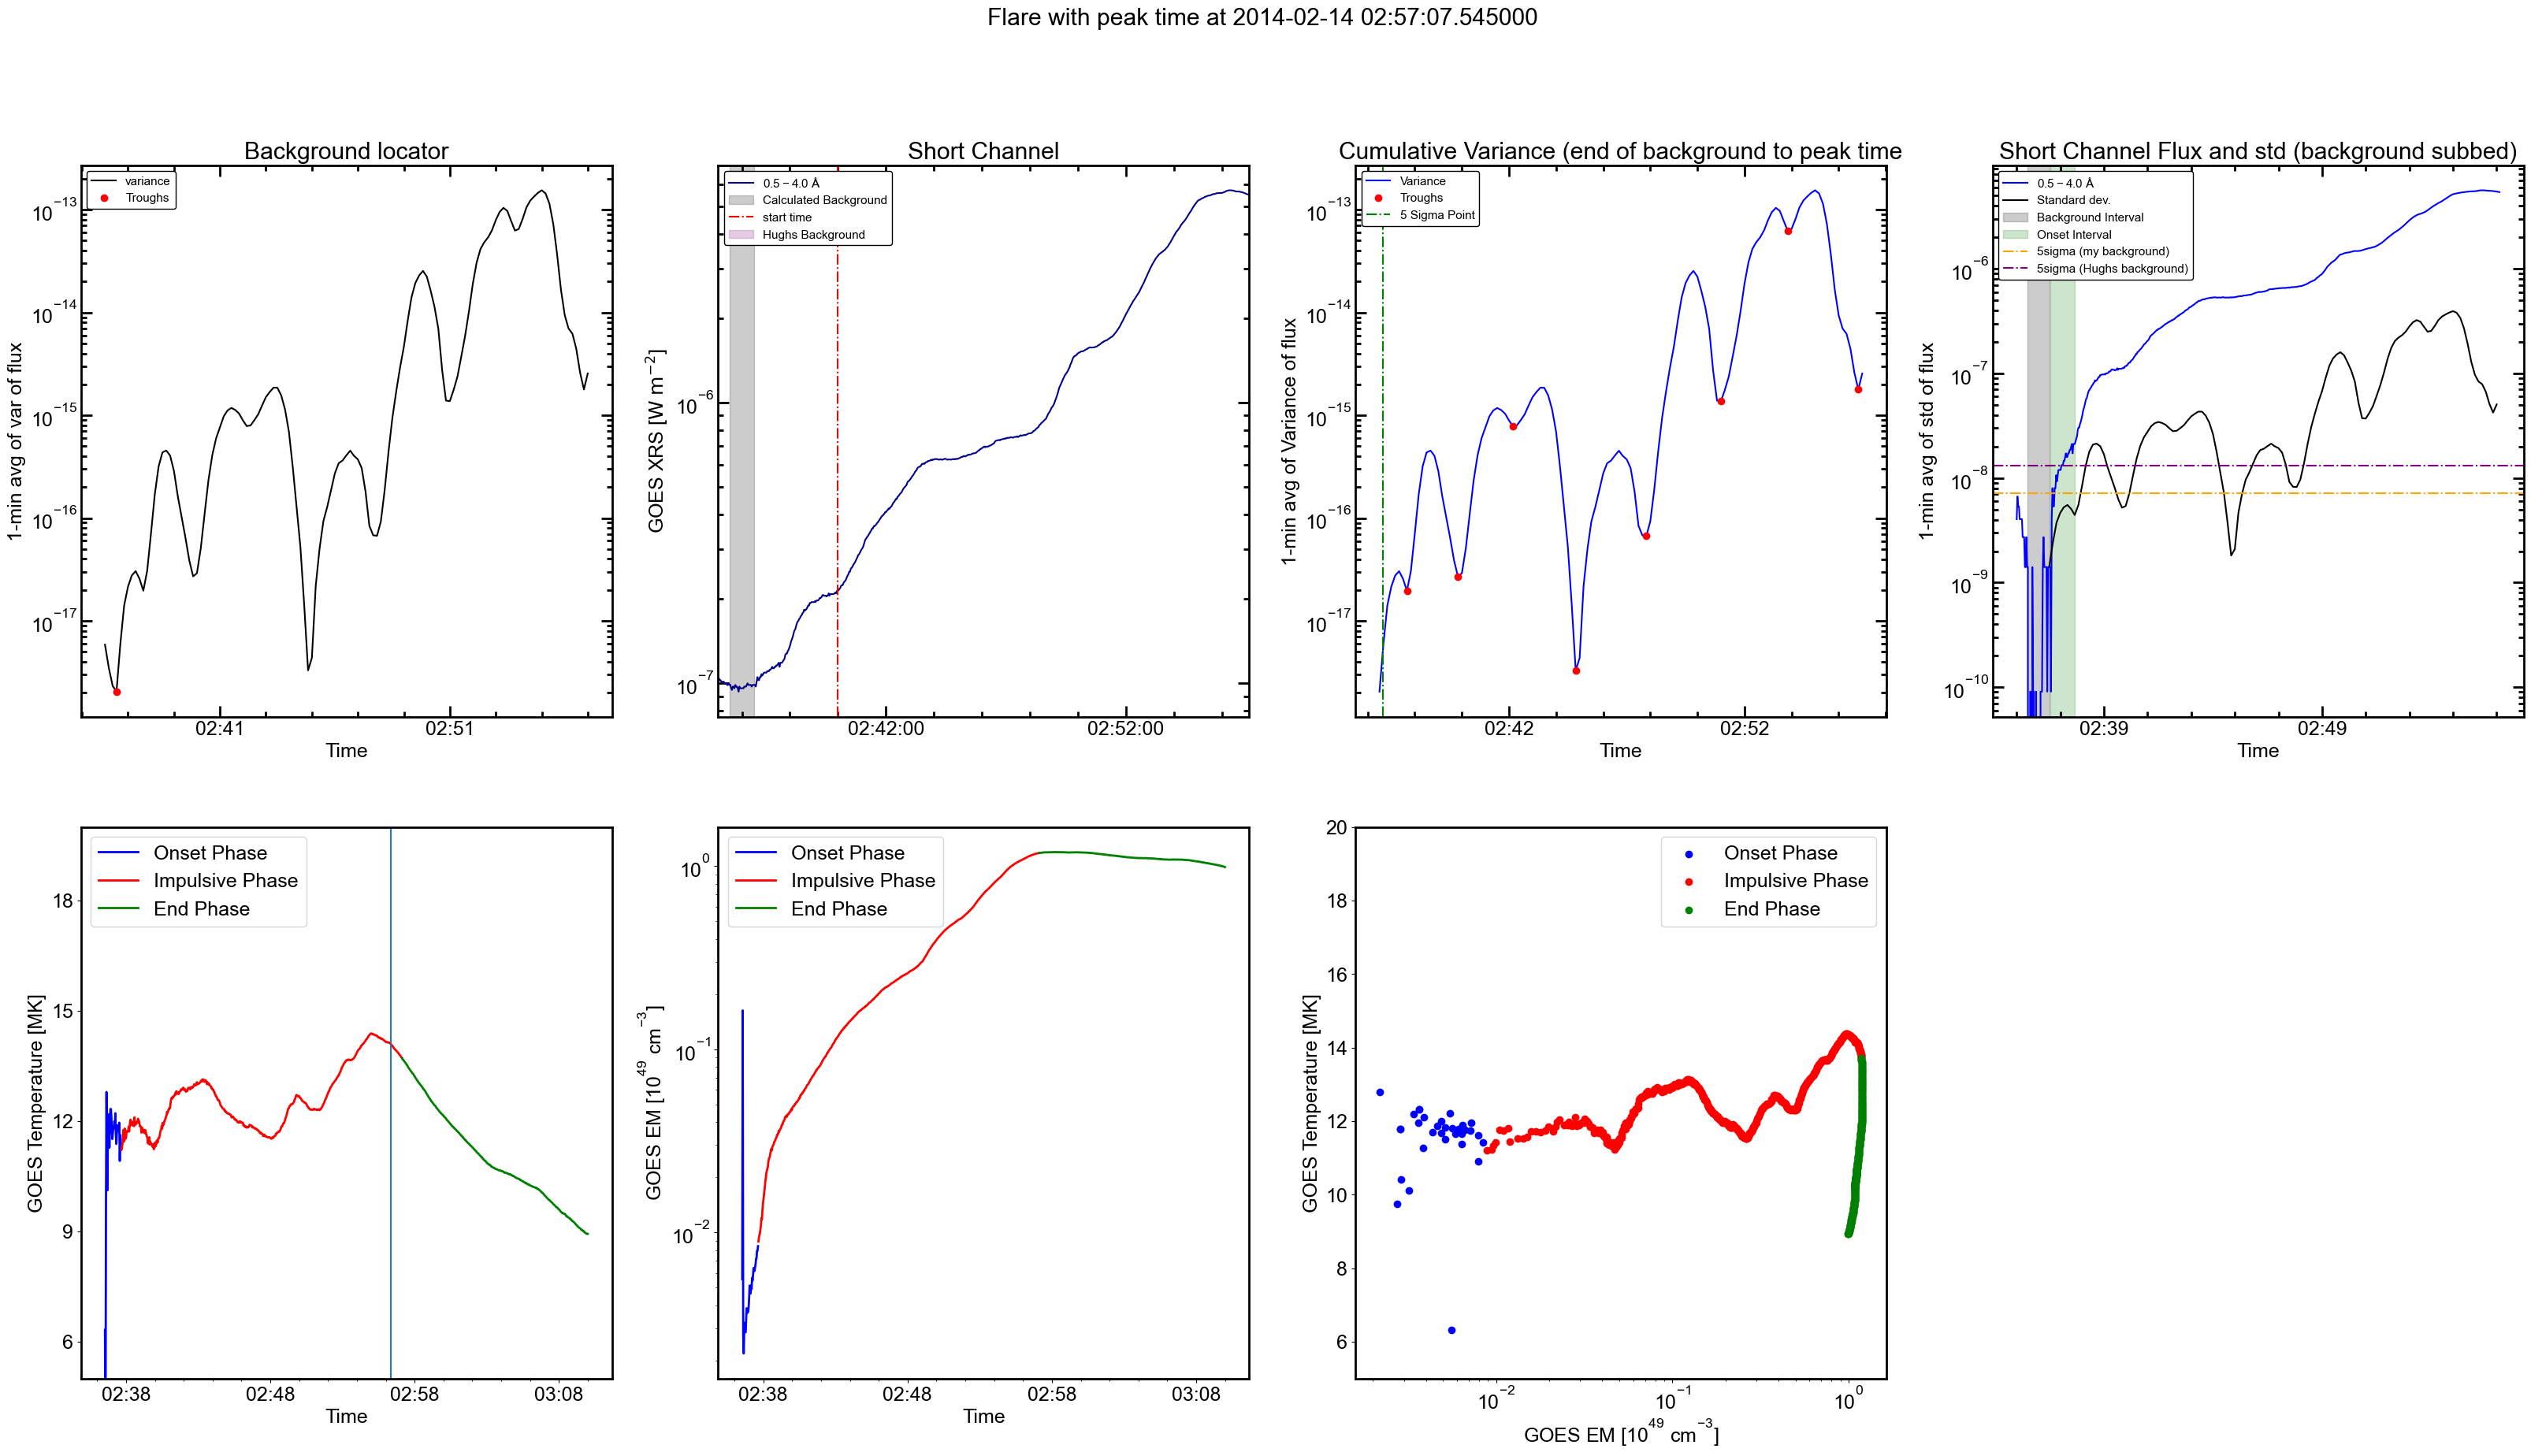

In [18]:
data_dir = r"C:\Users\William\Documents\University\MastersProj\Data\Test\GOES15_2s"

#Looping through all goes-15 flares in directory
for index, row in times_df.iterrows():
     tsearch = a.Time(row['Start Time'], row['End Time'])
     day_string = tsearch.start.datetime.date().strftime("%Y%m%d")
     fl_path = os.path.join(data_dir,f'*g15*{day_string}*.nc')

     #tries to load in the file, if it does not exist, it will download it.
     try:
          ts.TimeSeries(fl_path, concatenate=True)
          #print("File Exists")
     except ValueError:
          print("File does not exist.... Downloading file....")
          data_download(row)

# Load flare into time series
     g15 = ts.TimeSeries(fl_path, concatenate=True)
     df_long = pd.Series(g15.quantity("xrsb").value, index = pd.DatetimeIndex(g15.index))
     df_short = pd.Series(g15.quantity("xrsa").value, index = pd.DatetimeIndex(g15.index))
     
     #Data pre-processing - though having difficulty making sure long and short channel fluxes stay the same length.
     # df_raw = pd.DataFrame({"xrsa": g15.quantity("xrsa").value, "xrsb": g15.quantity("xrsb").value})
     # df_raw.set_index(g15.index)
     # df_raw.index = pd.to_datetime(df_raw.index)
     # df_raw = df_raw.dropna()
     # # #df_raw = df_raw.drop(df_raw[df_raw <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-10)
     # df_short = pd.Series(d["xrsa"].values, index = pd.DatetimeIndex(df_raw.index))
     # df_long = pd.Series(df_raw["xrsb"].values, index = pd.DatetimeIndex(df_raw.index))
     # df_sr = df_short.dropna()
     # df_sr = df_short.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-10)
     # df_lg = df_long.dropna()
     # df_lg = df_long.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-10)


#Calculating background of non-backsubbed peak
     flare_time=a.Time(Time(row['Start Time'], scale='utc').iso, Time(row['End Time'],scale='utc').iso)
     bcktrunc_18=df_long.truncate(flare_time.start.iso,flare_time.end.iso)
     old_peak = bcktrunc_18.idxmax()


# Background Time Calculation Function
     #bckt, bcktrunc_054, bcktrunc_18, bckdata = background_2(df_short, df_long, start_time = Time(row['Start Time']), peak_time = Time(row['Peak Time']))
     bck_startt, bck_endt, smooth_bck, bck_tr_ts, bck_tr_vars = background_2(df_short, df_long, start_time = Time(row['Start Time']), peak_time = old_peak)
     srch_time=a.Time(Time(bck_startt, scale='utc').iso, Time(bck_endt,scale='utc').iso)
     trunc_054 = df_short.truncate(srch_time.start.iso,srch_time.end.iso)
     trunc_18 = df_long.truncate(srch_time.start.iso,srch_time.end.iso)
     bck_t = trunc_054.index
     bck_short = np.mean(trunc_054)
     bck_long = np.mean(trunc_18)
     bck_short_std = np.std(trunc_054)

     # Printing out some info on the background
     bck_paper_054 = df_short.truncate(Time(row['Background Start']).datetime, Time(row['Background End']).datetime)
     bck_paper_18 = df_long.truncate(Time(row['Background Start']).datetime, Time(row['Background End']).datetime)
     bck_paper_054_avg = np.mean(bck_paper_054)
     bck_paper_18_avg = np.mean(bck_paper_18)
     print("")
     print("---------Background Time Information---------")
     print(f"Our background timings are between: {bck_startt} and {bck_endt}")
     print(f"The paper's used backgrounds are {row['Background Start']} and {row['Background End']}")
     print("")
     print(f"Our calculated backgrounds are: {bck_short:.3e} for the short channel and {bck_long:.3e} for the long channel")
     print(f"The Paper's used backgrounds are: {bck_paper_054_avg:.3e} for the short channel and {bck_paper_18_avg:.3e} for the long channel")
     print("")

     # Background Subtracting the Data
     short_backsub = df_short - bck_short
     long_backsub = df_long - bck_long

# Calculating true peak time (using long channel flux)
     flare_long = long_backsub.truncate(flare_time.start.iso,flare_time.end.iso)
     true_peak = flare_long.idxmax()

# Calculating true peak time (using long channel flux)
     flare_short = short_backsub.truncate(flare_time.start.iso,flare_time.end.iso)
     short_peak = flare_short.idxmax()

     print("")
     print("---------Peak time Information---------")
     print(f"Given peak is: {row['Peak Time']}")
     print(f"Non-backsubbed long channel peak is: {old_peak}")
     print(f"backsubbed Short channel peak is: {true_peak}")
     print("")

# Onset Time Calculation Function
     onset_start, onset_end, smooth_onset, onset_troughs_tims, onset_troughs_var, five_sig_tim = onset_times(short_backsub, bck_endt, true_peak, bck_short_std)
     print("")
     print("---------Onset Time Information---------")
     print(f"The start of the onset is calculated to be: {onset_start}")
     print(f"The end of the onset is calculated to be: {onset_end}")


# TEM Caculation
     trunc_054_tem_onset = short_backsub.truncate(onset_start, onset_end)
     trunc_18_tem_onset = long_backsub.truncate(onset_start, onset_end)

     trunc_054_tem_imp = short_backsub.truncate(onset_end, Time(true_peak).datetime)
     trunc_18_tem_imp = long_backsub.truncate(onset_end, Time(true_peak).datetime)

     trunc_054_tem_end = short_backsub.truncate(Time(true_peak).datetime, Time(row['End Time']).datetime)
     trunc_18_tem_end = long_backsub.truncate(Time(true_peak).datetime, Time(row['End Time']).datetime)

     tmk, em = gtem.get_tem(trunc_18_tem_onset, trunc_054_tem_onset) 
     tmk_imp, em_imp = gtem.get_tem(trunc_18_tem_imp, trunc_054_tem_imp) 
     tmk_end, em_end = gtem.get_tem(trunc_18_tem_end, trunc_054_tem_end)   

     tmk_mnho=np.mean(tmk)   #calculating mean T, EM for backsubbed new data.
     em_mnho=np.mean(em)
     print("")
     print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
     print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho))
     print("")
     
# Plotting
     # Truncate data to range (5 mins before start time till peak time)
     bcktime, bcktrunc_054, bcktrunc_18 = bck_truncate(short_backsub, long_backsub, Time(row['Start Time']), 600, 0)
     trunc_time, trunc_054, trunc_18 = bck_truncate(df_short, df_long, Time(row['Start Time']), 600, 0)
     trunc_054_p = short_backsub.truncate((Time(row['Start Time'], scale = 'utc') - TimeDelta(300, format='sec')).iso, Time(true_peak, scale = 'utc').iso)
     trunc_18_p = long_backsub.truncate((Time(row['Start Time'], scale = 'utc') - TimeDelta(300, format='sec')).iso, Time(true_peak, scale = 'utc').iso)
     trunc_054_z = df_short.truncate((Time(row['Start Time'], scale = 'utc') - TimeDelta(300, format='sec')).iso, Time(true_peak, scale = 'utc').iso)
     
     fig= plt.figure(figsize=(40, 20))
     fig.suptitle(f'Flare with peak time at {true_peak}')
     #background Loacator graph
     ax_bck = fig.add_subplot(2,4,1)
     ax_bck.plot(smooth_bck.index, smooth_bck['Variance'], color = 'black', label = 'variance')
     ax_bck.plot(bck_tr_ts, bck_tr_vars, 'o', color = 'red', label = 'Troughs')
     ax_bck.set_title("Background locator")
     ax_bck.set_ylabel("1-min avg of var of flux")
     ax_bck.set_xlabel("Time")
     ax_bck.set_yscale("log")
     myFmt = matplotlib.dates.DateFormatter('%H:%M')
     majorx= matplotlib.dates.MinuteLocator(interval=10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     ax_bck.xaxis.set_major_locator(majorx)
     ax_bck.xaxis.set_minor_locator(minorx)
     ax_bck.xaxis.set_major_formatter(myFmt)
     ax_bck.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
     ax_bck.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
     ax_bck.tick_params(which='major', size=10, width=2, direction='in', right='on')
     ax_bck.tick_params(which='minor', size=5, width=2, direction='in', right='on')
     ax_bck.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

     #Short Channel XRS Flux
     ax_short = fig.add_subplot(2, 4, 2)
     ax_short.plot(trunc_054_z.index, trunc_054_z, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
     ax_short.axvspan(bck_startt.datetime, bck_endt.datetime, color='black',alpha=0.2, label = 'Calculated Background')
     ax_short.axvline(Time(row["Start Time"]).datetime,ls='-.',color = 'red',label = "start time")
     ax_short.axvspan(Time(row['Background Start']).datetime, Time(row['Background End']).datetime, color = 'Purple', alpha = 0.2,label = 'Hughs Background')
     ax_short.set_title("Short Channel")
     ax_short.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
     ax_short.set_xlim(min(trunc_054_z.index), max(trunc_054_z.index))
     ax_short.set_yscale("log")
     myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
     majorx= matplotlib.dates.MinuteLocator(interval= 10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     ax_short.xaxis.set_major_locator(majorx)
     ax_short.xaxis.set_minor_locator(minorx)
     ax_short.xaxis.set_major_formatter(myFmt)
     ax_short.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
     ax_short.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
     ax_short.tick_params(which='major', size=10, width=2, direction='in', right='on')
     ax_short.tick_params(which='minor', size=5, width=2, direction='in', right='on')
     ax_short.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

     #Variance plot showing onset interval determination
     ax_onset = fig.add_subplot(2, 4, 3)
     ax_onset.set_title('Cumulative Variance (end of background to peak time')
     ax_onset.plot(smooth_onset, color = 'blue', label = 'Variance')
     # ax_onset.axvspan(onset_start, onset_end, color = 'green', alpha = 0.2, label = 'Onset Interval')
     ax_onset.plot(onset_troughs_tims, onset_troughs_var, 'o', color = 'red', label = 'Troughs')
     ax_onset.axvline(five_sig_tim, ls = '-.', color = 'green', label = '5 Sigma Point' )
     ax_onset.set_ylabel("1-min avg of Variance of flux")
     ax_onset.set_xlabel("Time")
     ax_onset.set_yscale("log")
     myFmt = matplotlib.dates.DateFormatter('%H:%M')
     majorx= matplotlib.dates.MinuteLocator(interval=10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     ax_onset.xaxis.set_major_locator(majorx)
     ax_onset.xaxis.set_minor_locator(minorx)
     ax_onset.xaxis.set_major_formatter(myFmt)
     ax_onset.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
     ax_onset.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
     ax_onset.tick_params(which='major', size=10, width=2, direction='in', right='on')
     ax_onset.tick_params(which='minor', size=5, width=2, direction='in', right='on')
     ax_onset.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

     #Short channel Flux Plot showing background and onset windows
     ax_final = fig.add_subplot(2, 4, 4)
     ax_final.set_title('Short Channel Flux and std (background subbed)')
     ax_final.plot(trunc_054_p.index, trunc_054_p, color = 'blue', label = r"$0.5-4.0\;\AA$")
     ax_final.plot(np.sqrt(smooth_onset), color = 'black', label = 'Standard dev.')
     ax_final.axvspan(bck_startt.datetime, bck_endt.datetime, color='black',alpha=0.2, label = 'Background Interval')
     ax_final.axvspan(onset_start, onset_end, color = 'green', alpha = 0.2, label = 'Onset Interval')
     ax_final.axhline(5*bck_short_std, color = 'Orange',ls = '-.' ,label = '5sigma (my background)')
     ax_final.axhline(5*np.std(bck_paper_054), color = 'purple',ls = '-.' ,label = '5sigma (Hughs background)')
     ax_final.set_ylabel("1-min avg of std of flux")
     ax_final.set_xlabel("Time")
     ax_final.set_yscale("log")
     myFmt = matplotlib.dates.DateFormatter('%H:%M')
     majorx= matplotlib.dates.MinuteLocator(interval=10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     ax_final.xaxis.set_major_locator(majorx)
     ax_final.xaxis.set_minor_locator(minorx)
     ax_final.xaxis.set_major_formatter(myFmt)
     ax_final.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
     ax_final.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
     ax_final.tick_params(which='major', size=10, width=2, direction='in', right='on')
     ax_final.tick_params(which='minor', size=5, width=2, direction='in', right='on')
     ax_final.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

     #Temperature vs Time
     ax1 = fig.add_subplot(2, 4, 5)
     ax1.plot(trunc_054_tem_onset.index, tmk, marker=None,color='blue',lw=2, label = 'Onset Phase')
     ax1.plot(trunc_054_tem_imp.index, tmk_imp, marker=None,color='red',lw=2, label = 'Impulsive Phase')
     ax1.plot(trunc_054_tem_end.index, tmk_end, marker=None,color='green',lw=2, label = 'End Phase')
     ax1.set_ylabel("GOES Temperature [MK]")
     ax1.set_xlabel("Time")
     ax1.set_ylim([5,20])
     ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
     ax1.axvline(Time(short_peak).datetime)
     #ax1.set_xlim([trange_small.start.datetime,trange_small.end.datetime])
     myFmt = matplotlib.dates.DateFormatter('%H:%M')
     majorx= matplotlib.dates.MinuteLocator(interval=10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     ax1.xaxis.set_major_locator(majorx)
     ax1.xaxis.set_minor_locator(minorx)
     ax1.xaxis.set_major_formatter(myFmt)
     plt.legend()

     #EM vs Time
     ax2 = fig.add_subplot(2, 4, 6)
     ax2.plot(trunc_054_tem_onset.index, em*1e-49,marker=None,color='blue',lw=2, label = 'Onset Phase') 
     ax2.plot(trunc_054_tem_imp.index, em_imp*1e-49,marker=None,color='red',lw=2, label = 'Impulsive Phase')
     ax2.plot(trunc_054_tem_end.index, em_end*1e-49, marker=None,color='green',lw=2, label = 'End Phase')
     ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
     ax2.set_xlabel("Time")
     #ax2.set_ylim([1e-3,1e1])
     ax2.set_yscale("log")
    # ax2.set_xlim([trange_small.start.datetime,trange_small.end.datetime])
     myFmt = matplotlib.dates.DateFormatter('%H:%M')
     majorx= matplotlib.dates.MinuteLocator(interval=10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     ax2.xaxis.set_major_locator(majorx)
     ax2.xaxis.set_minor_locator(minorx)
     ax2.xaxis.set_major_formatter(myFmt)
     plt.legend()

     #EM vs Temperature
     ax3 = fig.add_subplot(2, 4, 7)
     ax3.scatter(em*1e-49, tmk, marker = None, color = 'blue', label = 'Onset Phase')
     ax3.scatter(em_imp*1e-49,tmk_imp,marker=None,color='red', label = 'Impulsive Phase')
     ax3.scatter(em_end*1e-49,tmk_end,marker=None,color='green', label = 'End Phase')
     ax3.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
     ax3.set_ylabel("GOES Temperature [MK]")
     ax3.set_xscale("log")
     majorx= matplotlib.dates.MinuteLocator(interval=10)
     minorx= matplotlib.dates.MinuteLocator(interval=2)
     #ax3.set_xlim([1e-3,1e1])
     ax3.set_ylim([5,20])
     plt.legend()
     
     plt.show()

### Background Notes
- sorted by variance gives the 'flattest' regions
- Need to take the variables and work out how to bias times closer to start time (do we need to?? - just reduce the window range would bias this)
- Note the 2012-05-14 flare is messed up - possibly the data - need to flag this
- Current background seems to work ok
- need to implement code that will append data together at midnight if necessary


### Onset Notes
- third flare cannot find enough troughs (look into this)
- 2011-08-09 flare is too slow and troughs are picked up when there shouldnt be
- Using start time at all messes up a bunch of results that skips over the onset (but fixes earlier ones). Which means we need to rely on background end time. This background needs to be biased closer to the onset (diff method required? - using variance?)
- 